In [561]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.keras import TqdmCallback

from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
from pandas.core.indexing import _IndexSlice
import matplotlib.pyplot as plt
from functools import partial
import umap
from sklearn.preprocessing import StandardScaler
from pandas.core.dtypes.common import is_numeric_dtype, is_object_dtype
import datetime

import itertools

import thesis_layout as tl

from pathlib import Path

import common_functions as fnc

idx: _IndexSlice = pd.IndexSlice

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [562]:
from data_import import df, samples, didx, DATA_PATH

## Example plots

Text(0.5, 1.0, 'AquaPen - Example')

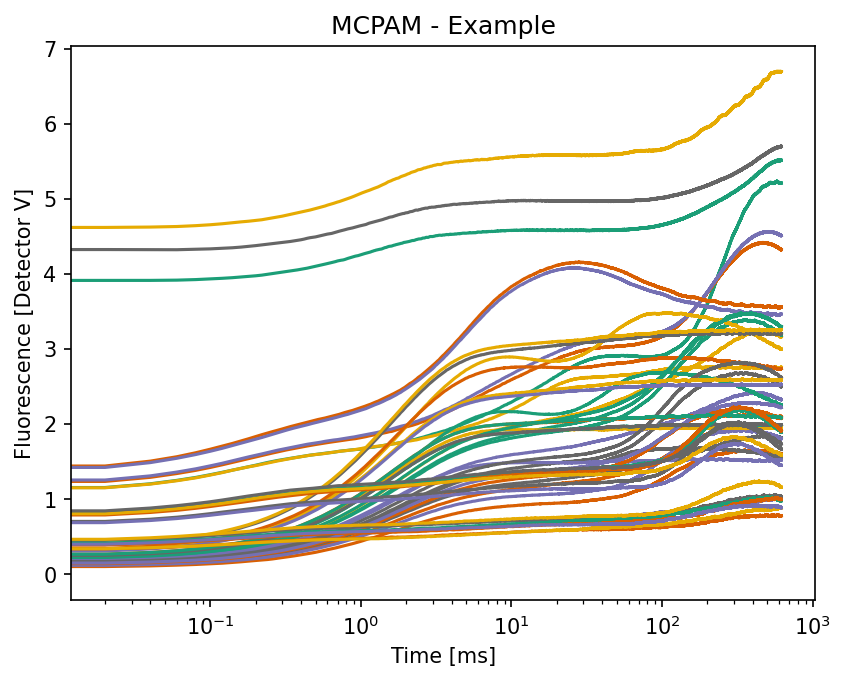

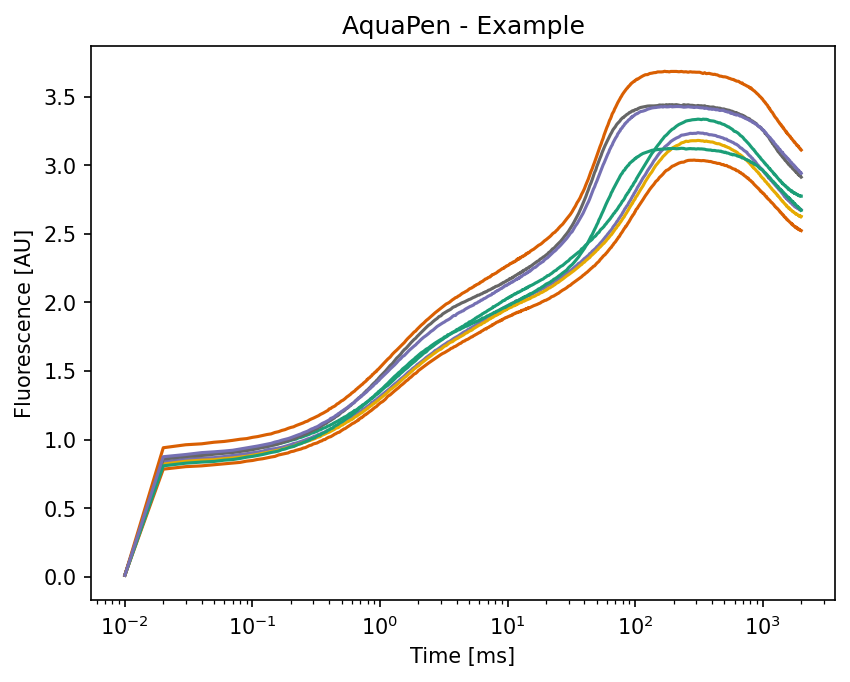

In [563]:
# Example plots
ax = df.loc[:, didx(
    fluorometer="MULTI-COLOR-PAM",
    CO2_level="Air", 
    strain="Chlorella vulgaris",
    # SP_color=455
)].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [Detector V]")
ax.set_title("MCPAM - Example")

ax = df.loc[:, didx(fluorometer="AquaPen", CO2_level="Air")].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [AU]")
ax.set_title("AquaPen - Example")

# Model training

In [564]:
SEED = 42

## Select the data to be trained on

In [565]:
dat = df.loc[
    0.01:, : # Exclude data before the light pulse
    # didx(
    #     fluorometer="MULTI-COLOR-PAM", # Only use MCPAM data
    #     strain='Synechocystis sp. PCC 6803', # Only use Synechocystis data
    # )
].dropna()

In [566]:
# Double normalise the OJIP data
dat_norm = dat - dat.iloc[0]
dat_norm = dat_norm / dat_norm.max()
dat_norm.columns = dat_norm.columns.get_level_values(0)

In [567]:
# Find outliers that are at least 5% (Fm-F0) below F0
dat_exclude = (dat_norm < -0.05).any()

# Exclude them
dat_norm = dat_norm.loc[:,np.invert(dat_exclude)]

### Map the treatment effects

In [568]:
# test  = pd.read_csv(
#     DATA_PATH / "effects_map.csv",
#     header=[0,1],
#     index_col=[0,1],
#     ).astype(float).fillna(0).astype(bool)

In [569]:
# Read the map of effects transformed into one-hot encoding
effects_map_raw = pd.read_csv(
    DATA_PATH / "effects_map.csv",
    header=[0,1],
    index_col=[0,1],
    ).astype(float).fillna(0).astype(bool)

# Exclude Light intensity and temperature from targets
effects_map = effects_map_raw[[
    'control_measurement',
    'PSII_closed',
    'CBB_inhibited',
    'TOX_inhibited',
    'electron_drain'
]]

# Set High light as a closing factor of PSII
effects_map.loc[:,'PSII_closed'] = np.logical_or(
    effects_map['PSII_closed'].to_numpy(),
    effects_map_raw["high_light"].to_numpy()
)

# Ass high and low temperature as 
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["low_temperature"].to_numpy()
)
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["high_temperature"].to_numpy()
)
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["low_light"].to_numpy()
)

# Get the effects and map the mto the targets
effects = samples.loc[dat.columns.get_level_values(0), ["Effect in PSET", "Treatment"]]

targets = effects_map.loc[pd.MultiIndex.from_frame(effects)].droplevel(1, axis=1)
targets = targets.astype(int)
targets.index = dat.columns

# Make a Multiindex with a duplicated entries
target_names = targets.columns
targets.columns = pd.MultiIndex.from_arrays(arrays=[targets.columns, targets.columns])

# Select features

**Message from Tomas:**

INPUTS
- Strain: Synechocystis / Chlorella. Later, when we have more strains measured, we can make it more general like green algae/cyanobacteria.
- Temperature: **it could be enough to keep it in intervals, like e.g. 15-20 / 20-25 / 25-30 / 30-35 etc.**
- Light acclimation state: light-acclimated / dark-acclimated
- OD: needs to be standardized = measured by one device since each device measure OD differently.  In the dataset we now have it for Multi-Cultivator, but it would be better to refer to UV-Vis and 1 cm cuvette. Alternatively, chlorophyll content could work well. I can provide all these values, based on additional measurements that we have already performed.
- SP color: **blue / orange-red could be enough**
- SP Intensity: saturating / non-saturating. This parameter definitely matters, but it could be tricky for the users to validate if SP is saturating or not. So, alternatively, the user can provide SP intensity (**perhaps again in some intervals like < 1000 / 1000-1500 / 1500-2000 / 2000-2500 / >2500**) and we can evaluate by our algorithm if the SP was saturating, based on the selection of strain, OD, SP color and SP intensity.
- Fluorometer: MCPAM / AquaPen - I would keep it for now, since I am still not sure if there is any fundamental difference between MC-PAM, AquaPen and FL-6000, or not. But in general, it should be only SP color and SP intensity that matter the most
- These parameters might be not necessary, but I am not sure - the OJIP curves were different under these specific acclimations, so it could make the predictions better if we discriminate also these acclimations - but on the other hand, it might be overkill:
  - CO2 level
  - Growth light color

OUTPUTS
- PSII closed: DCMU, high light
- CBB inhibited: Glycolaldehyde
- TOX inhibited: KCN
- Electron drain from PSI: Methylviologen. Btw. yes, this effect should be the opposite of Glycolaldehyde treatment
- **PQ redox state: reduced / oxidized**
- It would be great to include more inhibitors, to describe more effects -we can do that later:
  - Cyt b6/f closed: DBMIB
  - Cyclic electron flow around PSI closed: Antimycin A3


## Get experimental conditions

In [570]:
# Get the conditions as the Multiindex-columns
conditions = dat.columns.to_frame()
# conditions.index = dat.columns.get_level_values(0)

# Select the relevant columns
condition_types = pd.Series({
    'Strain': "string",
    'CO2 level': "string", # There is a meaning to a higher CO2 concentration (maybe make categorical?)
    'Cultivation + experiment temperature': ("bucket", [15, 20, 25, 30, 35]),
    'Cultivation light intensity': "numeric",
    'Dark or light acclimated': "string",
    'Growth light color (nm)': "string",
    'Fluorometer': "string",
    'SP color (nm)': "int64", # There is no linear relationship between wavelength and effect
    'SP intensity': ("bucket", [1000, 1500, 2000, 2500]),
    'OD680 MC-1000': "numeric",
    'OD720 MC-1000': "numeric",
})

conditions = conditions[condition_types.index]

# Make a Multiindex with a duplicated entries
conditions.columns = pd.MultiIndex.from_arrays([conditions.columns, conditions.columns])

In [571]:
# Define model labels usable for models
condition_labels = pd.Series({
    'Strain': "strain",
    'CO2 level': "CO2", # There is a meaning to a higher CO2 concentration (maybe make categorical?)
    'Cultivation + experiment temperature': "temperature",
    'Cultivation light intensity': "glintensity",
    'Dark or light acclimated': "acclimation",
    'Growth light color (nm)': "glcolor",
    'Fluorometer': "fluorometer",
    'SP color (nm)': "spcolor", # There is no linear relationship between wavelength and effect
    'SP intensity': "spintensity",
    'OD680 MC-1000': "OD680",
    'OD720 MC-1000': "OD720",
    "ojip": "ojip"
})

In [572]:
# Define labels for targets
target_labels = {
    "control_measurement":{"long": "Control (Unstressed)", "short": "Control"},
    "PSII_closed":{"long": "PSII closed (DCMU)", "short": "PSII closed"},
    "CBB_inhibited":{"long": "CBB inhibited (GA)", "short": "CBB inhibited"},
    "TOX_inhibited":{"long": "TOX inhibited (KCN)", "short": "TOX inhibited"},
    "electron_drain":{"long": "Electron drain (MV)", "short": "Electron drain"},
}

## OJIP per target

In [573]:
# Plot
categories = effects_map.columns.get_level_values(0)
fig = tl.thesis_figures["ojip_doublenorm"]["main"]
axes = fig.subplots(
    int(np.ceil(len(categories)/2)),
    2,
    sharex=True,
    sharey=True
)

for target, ax in zip(target_labels, axes.flatten()):
    # Create a mask to get the OJIP curves of the current target
    target_bool = targets[target].astype(bool).droplevel(list(range(1,20))).iloc[:,0]

    cur_dat = dat_norm.loc[:,target_bool]
    cur_dat_mean = cur_dat.T.mean()
    cur_dat_sd = cur_dat.T.std()

    ax.plot(cur_dat_mean)

    ax.fill_between(cur_dat.index, cur_dat_mean-cur_dat_sd, cur_dat_mean+cur_dat_sd, alpha=0.5)

    ax.set_xscale("log")

    ax.set_title(target_labels[target]["long"])
    ax.text(0.95,0.1,f"n={cur_dat.shape[1]}", ha="right", transform=ax.transAxes)

    # ax.axhline(0, c="k", ls="--")

fig.suptitle("Double Normalized OJIP signals by target class")
fig.tight_layout()

axes[-2,-1].tick_params(labelbottom=True)
axes[-1,-1].remove()

for ax in axes[:,0]:
    ax.set_ylabel("Fluorescence [rel.]")

for ax in [axes[-1,0], axes[-1,1], axes[-2,-1]]:
    ax.set_xlabel("Time [ms]")

fig.tight_layout()

tl.label_axes(axes, pos="top left")

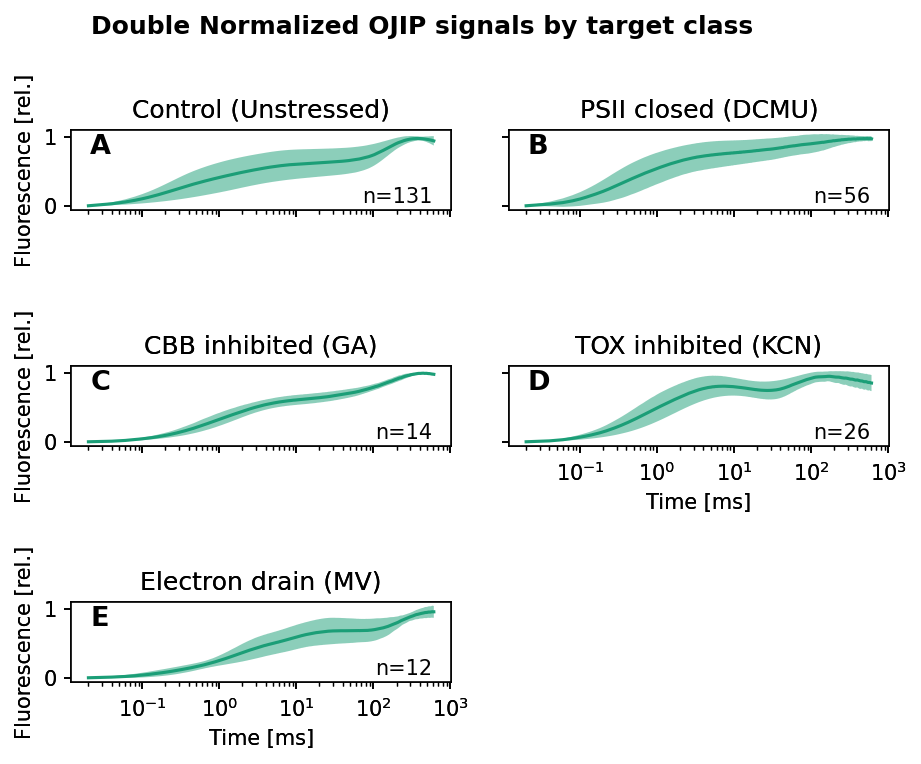

In [574]:
tl.thesis_figures["ojip_doublenorm"]["main"]

## Sample OJIP

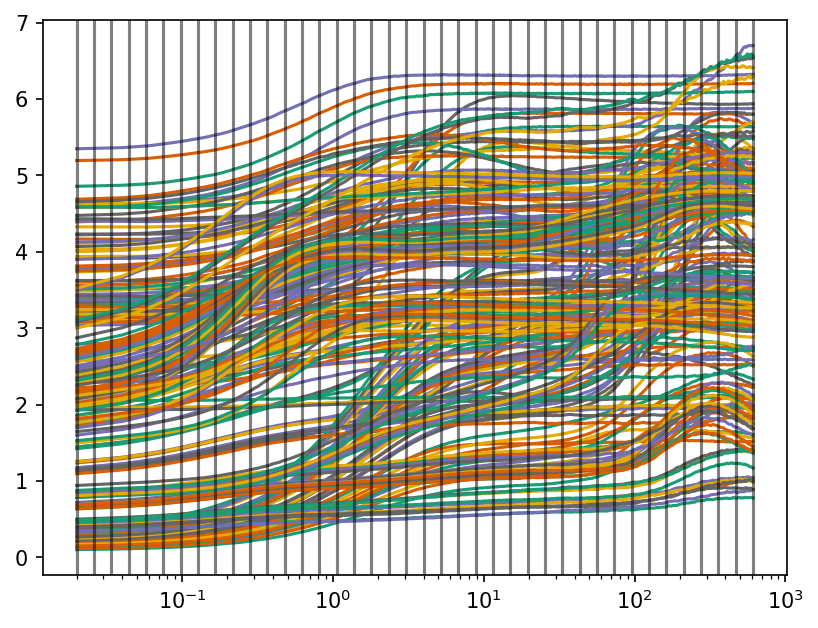

In [575]:
# Select the number of sampled points
n_points = 40

# Time points, logspaced
log_time_points = np.linspace(
    np.log10(dat.index[0]),
    np.log10(dat.index[-1]),
    n_points
)
time_points = 10 ** log_time_points

# Pre-populate the interp function
_interp = partial(np.interp, time_points, dat.index)

# Interpolate the selected points
ojip_sampled = dat.apply(_interp)
ojip_sampled.index = pd.MultiIndex.from_product([
    ["ojip"],
    ["ojip_" + x for x in log_time_points.round(2).astype(str)]
])

# Add sampled points to features
ojip_sampled = ojip_sampled.T

# Subset the data to the samples and time to be included in the analysis 
ax = dat.plot(legend=False)

for t in time_points:
    ax.axvline(t, c="k", alpha=0.5)

ax.set_xscale("log")

# Add data types
ojip_types = pd.Series({"ojip":"time-series-gradients"})

## Collect and split dataset

In [576]:
# Collect all data sets
dat_sets = [
    conditions,
    ojip_sampled,
    targets
]
dat_full = pd.concat(dat_sets, axis=1)

# Remove erroneous samples
dat_full = dat_full.drop(dat_exclude[dat_exclude].index)

# Split data into training set
dat_train, _dat_trainval = train_test_split(
    dat_full,
    test_size=0.3, 
    random_state=SEED,
    stratify=dat_full[target_names]
)

# Split data into test and validation set
dat_test, dat_val = train_test_split(
    _dat_trainval,
    test_size=0.3, 
    random_state=SEED,
    stratify=_dat_trainval[target_names]
)

print(f"Dimensions train: {dat_train.shape}, test: {dat_test.shape}, val: {dat_val.shape}")


if not np.all(dat_train[target_names].drop_duplicates().sum(axis=0) == 1):
    raise RuntimeError("Not all targets are in the training set")

# Make into dataset
train_ds = fnc.df_to_dataset(dat_train, targets=target_names, batch_size=64, shuffle=True)
test_ds = fnc.df_to_dataset(dat_test, targets=target_names, shuffle=False)
val_ds = fnc.df_to_dataset(dat_val, targets=target_names, shuffle=False)

Dimensions train: (167, 56), test: (50, 56), val: (22, 56)


In [577]:
# Create function that shuffles the targets in a DataFrame
def shuffle_targets(df: pd.DataFrame, targets=["control_measurement", "PSII_closed", "CBB_inhibited", "TOX_inhibited", "electron_drain"]) -> pd.DataFrame:
    _df = df.copy()
    _df.loc[:,targets] = _df.loc[:,targets].sample(frac=1).values
    return _df

# Make shuffled datasets for baseline models
train_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_train), targets=target_names, batch_size=64, shuffle=True)
# test_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_test), targets=target_names, shuffle=False)
# val_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_val), targets=target_names, shuffle=False)

In [578]:
?dense_models["model"].count_params

Object `dense_models["model"].count_params` not found.


In [579]:
?keras.Model.count_params

Signature: keras.Model.count_params(self)
Docstring:
Count the total number of scalars composing the weights.

Returns:
    An integer count.
File:      ~/miniforge3/envs/ojipml/lib/python3.12/site-packages/keras/src/layers/layer.py
Type:      function

## Get a latex list of all experiments

In [580]:
all_experiments = dat_full.reset_index()

all_experiments = all_experiments.loc[:, [
    "Strain",
    "Treatment",
    "CO2 level",
    "Cultivation + experiment temperature",
    "Cultivation light intensity",
    "Dark or light acclimated",
    # "Fluorometer",
    # "Growth light color (nm)",
    "SP color (nm)",
    "SP intensity",
    "control_measurement",
    "PSII_closed",
    "CBB_inhibited",
    "TOX_inhibited",
    "electron_drain"
]] #.drop_duplicates() #.droplevel(0, axis=1).droplevel(0,axis=0).

all_experiments = all_experiments.T.drop_duplicates().T

all_experiments = all_experiments

all_experiments.index = np.arange(all_experiments.shape[0])

# Formate the treatment columns
all_experiments.loc[:,["control_measurement","PSII_closed", "CBB_inhibited", "TOX_inhibited", "electron_drain"]] = all_experiments.loc[:,["control_measurement","PSII_closed", "CBB_inhibited", "TOX_inhibited", "electron_drain"]].replace({0:"", 1:"O"})

table_map = {
    "Treatment": "Treatment",
    "Strain": "Strain",
    "CO2 level": "CO$_2$ level",
    "Cultivation + experiment temperature": "Temperature",
    "Cultivation light intensity": r"AL intensity [\unit{\lightunit}]",
    "Dark or light acclimated": "Acclimation",
    # "Fluorometer",
    # "Growth light color (nm)",
    "SP color (nm)": "SP color [nm]",
    "SP intensity": r"SP intensity [\unit{\lightunit}]",
    "control_measurement": "Control",
    "PSII_closed": "PSII closed",
    "CBB_inhibited": "CBB inhibited",
    "TOX_inhibited": "TOX inhibited",
    "electron_drain": "Electron drain",
}

all_experiments.columns = [table_map[x] for x in all_experiments.columns.droplevel(1)]

all_experiments = all_experiments.value_counts()

# print(all_experiments.to_latex())

In [581]:
# Get the full number of classifications
target_counts = dat_full[[    "control_measurement",
    "PSII_closed",
    "CBB_inhibited",
    "TOX_inhibited",
    "electron_drain"]].sum().droplevel(1).sort_values(ascending=False)

target_counts.index = [table_map[x] for x in target_counts.index]

In [582]:
target_counts

Control           131
PSII closed        56
TOX inhibited      26
CBB inhibited      14
Electron drain     12
dtype: int64

In [583]:
print(target_counts.to_frame().T.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Control & PSII closed & TOX inhibited & CBB inhibited & Electron drain \\
\midrule
0 & 131 & 56 & 26 & 14 & 12 \\
\bottomrule
\end{tabular}



## Prepare data

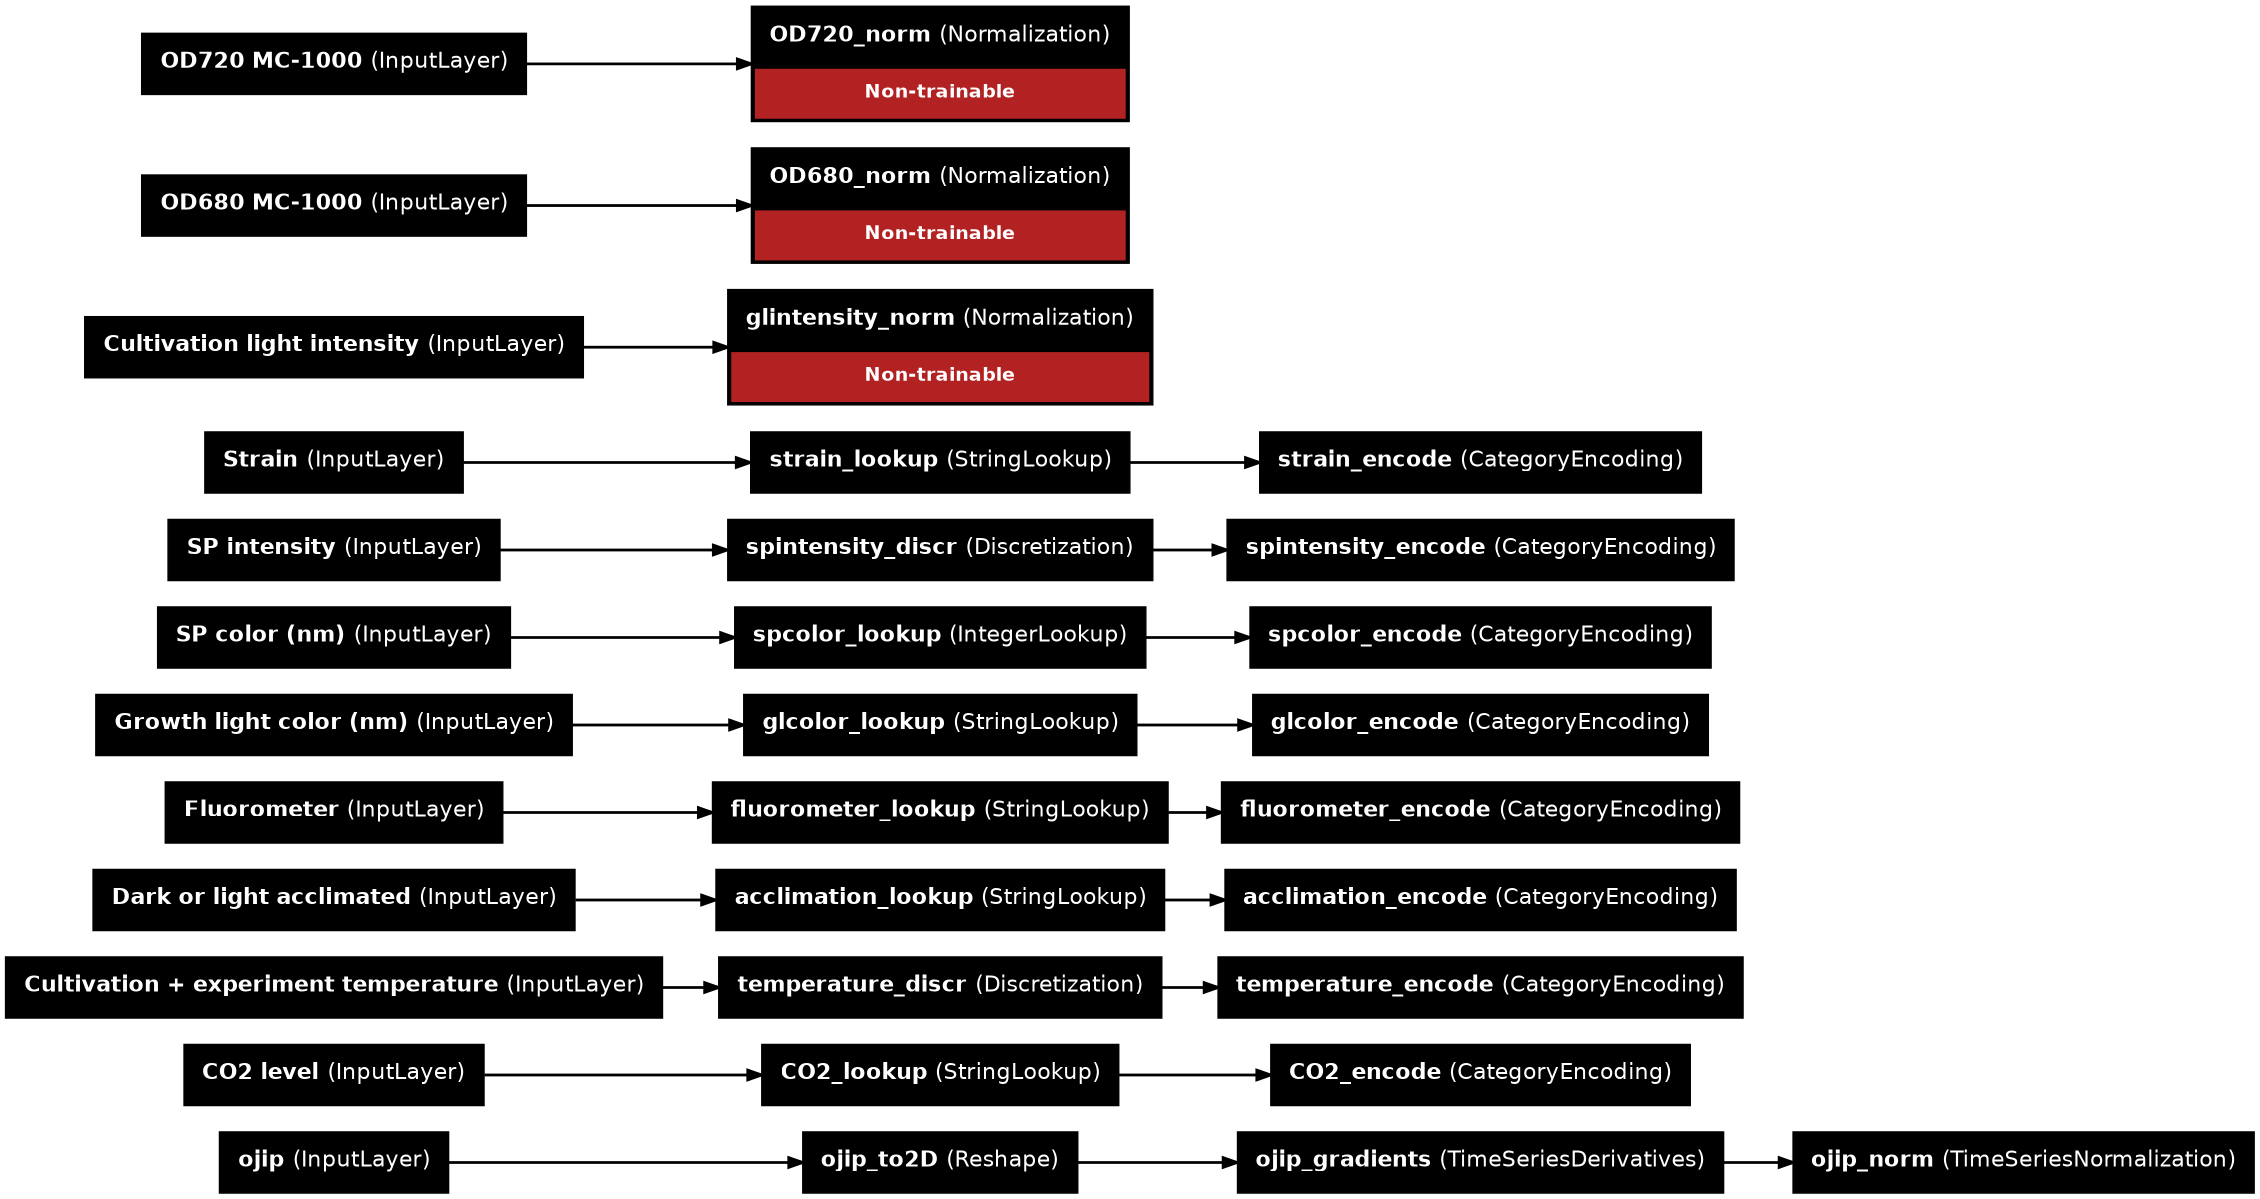

In [584]:
# Get the types of all features
feature_types = pd.concat([
    condition_types,
    ojip_types
])

# Create containers for inputs and encodings
all_inputs = {}
encoded_features_dict = {}
encoded_features = []

# Encode all features
for col_name, col_dtype in feature_types.items():

    if isinstance(col_dtype, str):
        # Create a numeric normalisation layer
        if col_dtype == "numeric":
            col = layers.Input(shape=(1,), name=col_name)
            normalization_layer = fnc.get_normalization_layer(col_name, train_ds, normLayer_name=f"{condition_labels[col_name]}_norm")
            encoded_col = normalization_layer(col)
        
        # Create a string enconding layer, could also work for integer encoding
        elif col_dtype in ["string", "int64"]:
            col = layers.Input(shape=(1,), name=col_name, dtype=col_dtype)
            encoding_layer = fnc.get_category_encoding_layer(name=col_name,
                                                        dataset=train_ds,
                                                        dtype=col_dtype,
                                                        max_tokens=5,
                                                        lookupLayer_name=f"{condition_labels[col_name]}_lookup",
                                                        encodingLayer_name=f"{condition_labels[col_name]}_encode",
                                                        )
            encoded_col = encoding_layer(col)

        # Create a layer to normalise time series and calculate gradients
        elif col_dtype == "time-series-gradients":
            col = layers.Input(shape=(dat_full[col_name].shape[1],), name=col_name)
            reshaped_col = layers.Reshape((dat_full[col_name].shape[1], 1), name=f"{condition_labels[col_name]}_to2D")(col)
            # normalization_layer = fnc.NormalizedTimeSeriesWithDerivatives()
            # encoded_col = normalization_layer(reshaped_col)

            gradient_layer = fnc.TimeSeriesDerivatives(name=f"{condition_labels[col_name]}_gradients")
            gradient_col = gradient_layer(reshaped_col)

            normalization_layer = fnc.TimeSeriesNormalization(name=f"{condition_labels[col_name]}_norm")
            encoded_col = normalization_layer(gradient_col)

        else:
            raise KeyError(f"No handling for col_dtype {col_dtype} defined")

    elif isinstance(col_dtype, tuple):
        # Create a discretized encoding for values with non-linear behaviour
        if col_dtype[0] == "bucket":
            col = layers.Input(shape=(1,), name=col_name, dtype="float32")
            encoding_layer = fnc.get_bucket_encoding_layer(name=col_name,
                                                        bin_boundaries=col_dtype[1],
                                                        dicretizationLayer_name=f"{condition_labels[col_name]}_discr", 
                                                        encodingLayer_name=f"{condition_labels[col_name]}_encode"
                                                        )
            encoded_col = encoding_layer(col)
        else:
            raise KeyError(f"No handling for col_dtype {col_dtype[0]} defined")
    else:
        raise KeyError(f"No handling for col_dtype {col_dtype} defined")

    all_inputs[col_name] = col
    encoded_features.append(encoded_col)
    encoded_features_dict[col_name] = encoded_col

# Define the preprocessing layer as a model
preprocessing_layer = keras.Model(
    all_inputs,
    encoded_features_dict,
    name="preprocessing_layer"
)
# Set the preprocessing layer to not be trainable
preprocessing_layer.trainable=False

# Plot the preprocessing layer
keras.utils.plot_model(
    preprocessing_layer,
    # show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    to_file="figures/preprocessing.png",
    show_trainable=True,
    dpi=100
)

## Show the condition combinations

In [585]:
# def _discretize_ranges(_range , _index, _all_index, conditions):
#     if _range[0] is None:
#         conditions[_index] = conditions[_all_index] < _range[1]
#     elif _range[1] is None:
#         conditions[_index] = conditions[_all_index] > _range[0]
#     else:
#         conditions[_index] = np.logical_and(
#             conditions[_all_index] >= _range[0],
#             conditions[_all_index] < _range[1],
#         )
#     return conditions

def _discretize_ranges(_range , value, _all_index, conditions):
    if _range[0] is None:
        _range_bool = conditions[_all_index] < _range[1]
    elif _range[1] is None:
        _range_bool = conditions[_all_index] >= _range[0]
    else:
        _range_bool = np.logical_and(
            conditions[_all_index] >= _range[0],
            conditions[_all_index] < _range[1],
        )
    conditions.loc[_range_bool, (f"_{_all_index[0]}", _all_index[1])] = value
    return conditions


def discretize_ranges(conditions, condition_name, ranges):
    # Encode temperature in ranges as one-hot
    _all_index = (condition_name, condition_name)
    conditions[(f"_{condition_name}", condition_name)] = conditions[_all_index].astype(str)
    for nam, _range in ranges.items():
        conditions = _discretize_ranges(_range , nam, _all_index, conditions)

    conditions[_all_index] = conditions[(f"_{condition_name}", condition_name)]
    conditions=conditions.drop((f"_{condition_name}", condition_name), axis=1)
    return conditions

In [586]:
# Get the unique levels for selected conditions
conditions_table = conditions[[
    "Strain",
    "CO2 level",
    "Cultivation + experiment temperature",
    "Cultivation light intensity",
    "Dark or light acclimated",
    # "Fluorometer",
    # "Growth light color (nm)",
    "SP color (nm)",
    "SP intensity",
]].copy()

# Add the type of treatment
conditions_table["Treatment type"] = [effects_map[target_names].columns.get_level_values(1).to_numpy()[x][0] for x in targets.astype(bool).to_numpy()]

# Get all unique entries per columns type
unique_conditions = conditions_table.apply(np.unique)

for col_name, col_dtype in condition_types.items():
    if isinstance(col_dtype,tuple) and col_dtype[0]=="bucket":
        _ranges = [None] + col_dtype[1] + [None]
        ranges = {f"{_ranges[i]} - {_ranges[i+1]}":_ranges[i:i+2] for i in range(len(_ranges)-1)}
        conditions_table = discretize_ranges(conditions_table, col_name, ranges)

        # Add all buckets to the unique values
        unique_conditions[(col_name, col_name)] = list(ranges.keys())


In [587]:

# # Add the type of treatment
# conditions_table["Treatment type"] = [effects_map[target_names].columns.get_level_values(1).to_numpy()[x][0] for x in targets.astype(bool).to_numpy()]

# # Get all unique entries per columns type
# unique_conditions = conditions_table.apply(np.unique)

# Create all possible conditions combinations
all_condition_counts = pd.Series(
    data=0, 
    index=pd.MultiIndex.from_tuples(
        list(itertools.product(*unique_conditions.to_numpy())),
        names=conditions_table.columns.get_level_values(0)
    )
)

# Create all possible conditions combinations
all_condition_counts = pd.Series(
    data=0, 
    index=pd.MultiIndex.from_tuples(
        list(itertools.product(*unique_conditions.to_numpy())),
        names=conditions_table.columns.get_level_values(0)
    )
)

# Count the observations of each condition combination and place the min the total table
condition_counts = pd.Series(dict(Counter([tuple(x) for x in conditions_table.to_numpy()])))

all_condition_counts.update(condition_counts)

all_condition_counts = pd.concat([
    all_condition_counts.loc[all_condition_counts>0].sort_values(ascending=False),
    all_condition_counts.loc[all_condition_counts==0].sort_index()
])

all_condition_counts.name = "Sample counts"

all_condition_counts.to_csv("out/ojip_sample_counts.csv")
print(f"number of cases not covered: {(all_condition_counts==0).sum()}")

number of cases not covered: 19145


## Create UMAP mapping

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


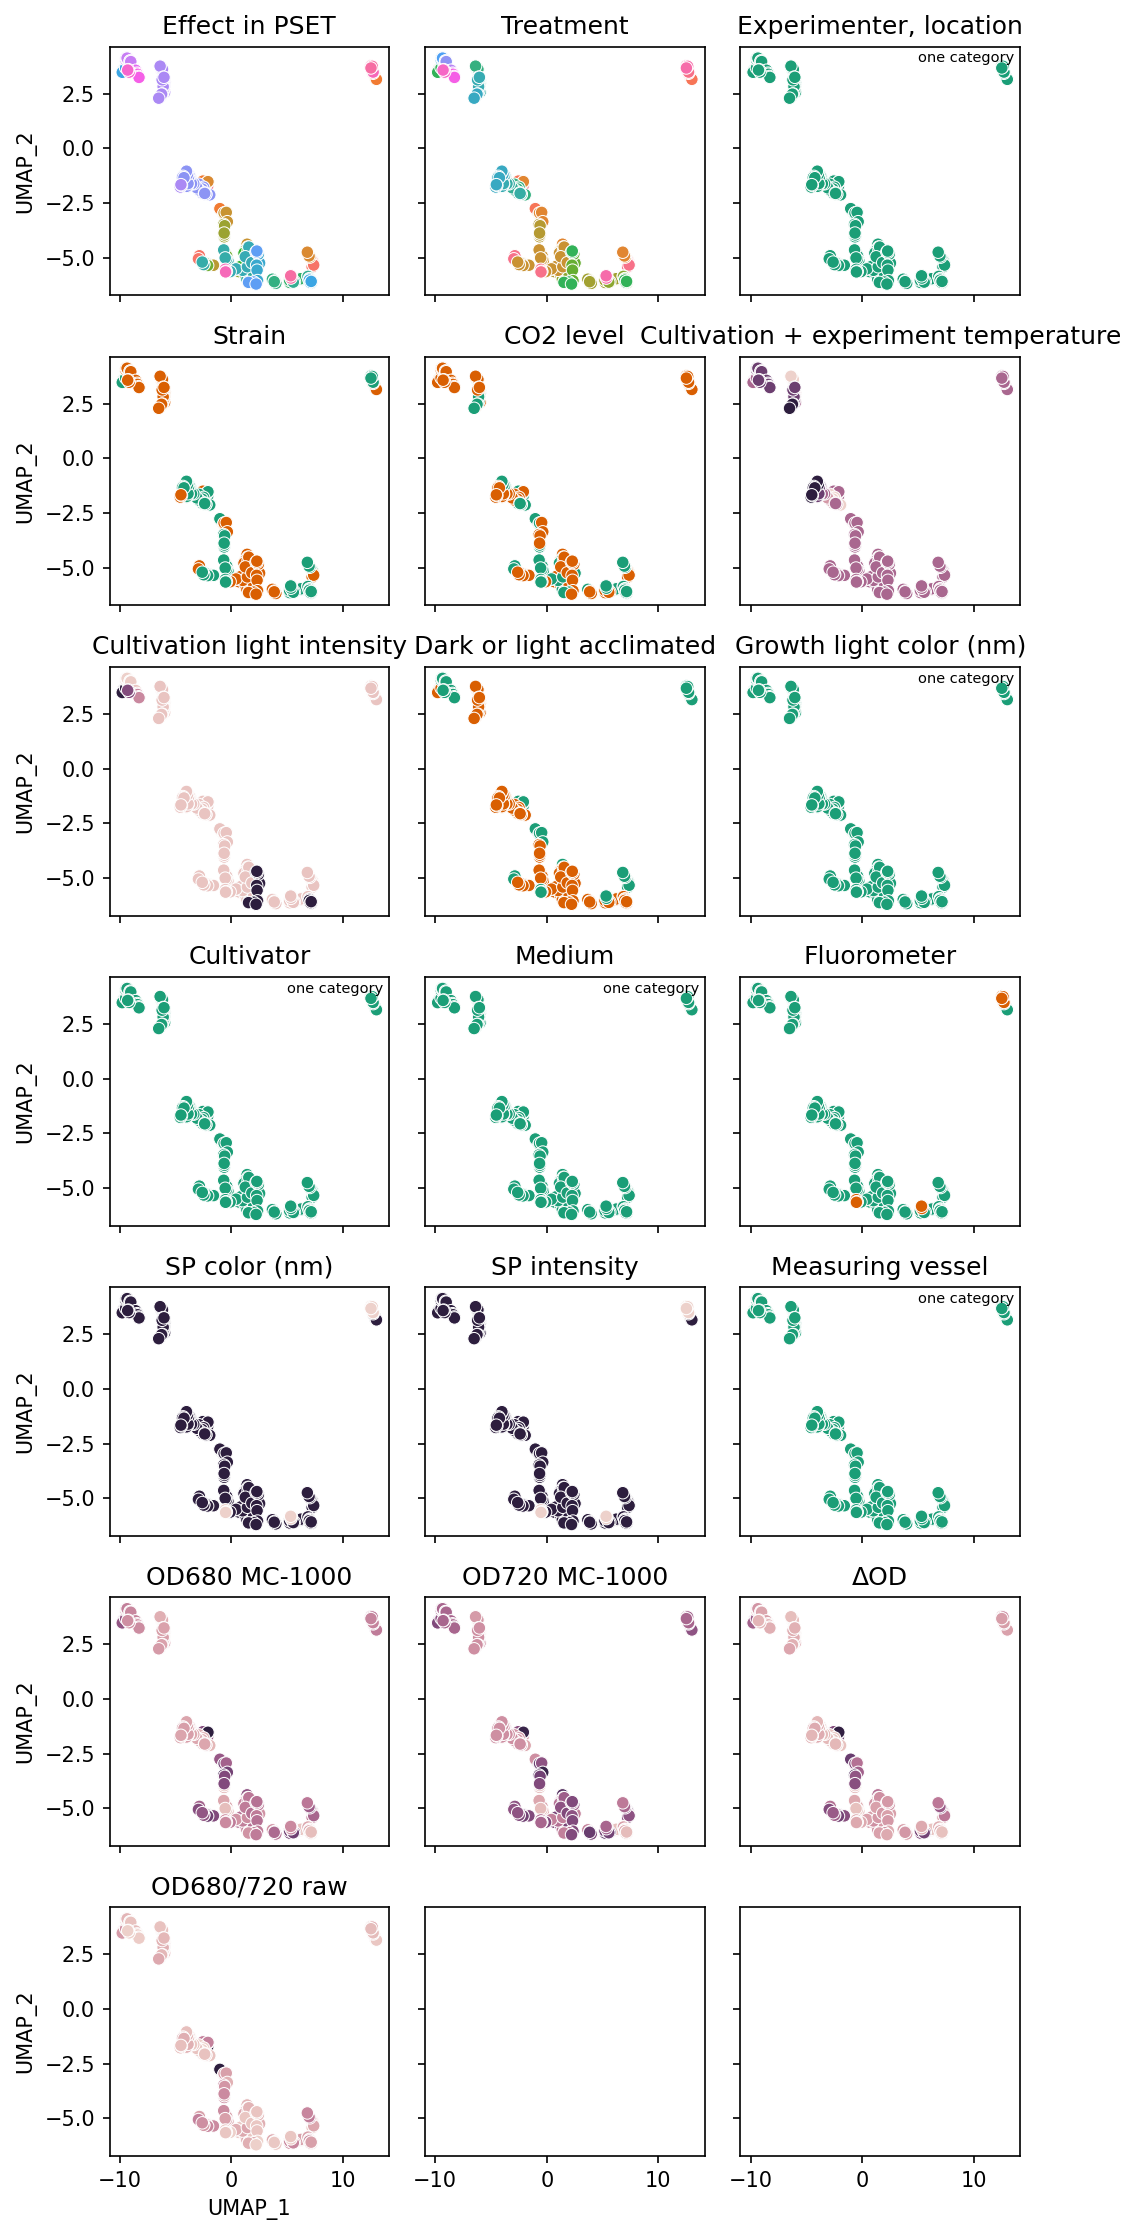

In [588]:
# Concatenate the outputs of the preprocessing layer to perform UMAP
preprocessed = preprocessing_layer(all_inputs)

# Append the derivatives of the ojip signal to the end to create a long feature vector
preprocessed["ojip"] = layers.Flatten()(preprocessed["ojip"])

concatenated_preprocess = keras.Model(
    all_inputs,
    layers.concatenate(list(preprocessed.values())),
    name="concatenation_layer"
)

# Scale the features
df_features_scaled = concatenated_preprocess.predict(
    fnc.get_dataset_from_input_df(dat_full, all_inputs)
)

# Create the UMAP embedding
reducer = umap.UMAP(random_state=SEED)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=dat_full.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()

# Plot
categories = df.columns.names[1:]
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,15),
    sharey=True,
    sharex=True,
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()
fig.savefig("figures/umap_conditions.png")

In [589]:
# Plot targest on UMAP
# Add UMAP to targets
embedding_targets = pd.concat([
    targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

# Plot
categories = effects_map.columns.get_level_values(0)
fig = tl.thesis_figures["umap_targets_all"]["main"]
axes = fig.subplots(
    int(np.ceil(len(categories)/2)),
    2,
    # sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(target_labels[category]["long"])

    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

for ax in axes.flatten()[:-3]:
    ax.tick_params(labelbottom=False)
    ax.set_xlabel("")

# axes[1,1].tick_params(bottom=True, labelbottom=True)
# axes[1,1].set_xlabel("UMAP 1")

fig.suptitle("Targets in UMAP embedding")

fig.tight_layout()

tl.label_axes(axes, pos=(0.03, 0.8), ha="left")

axes[-1,-1].remove()



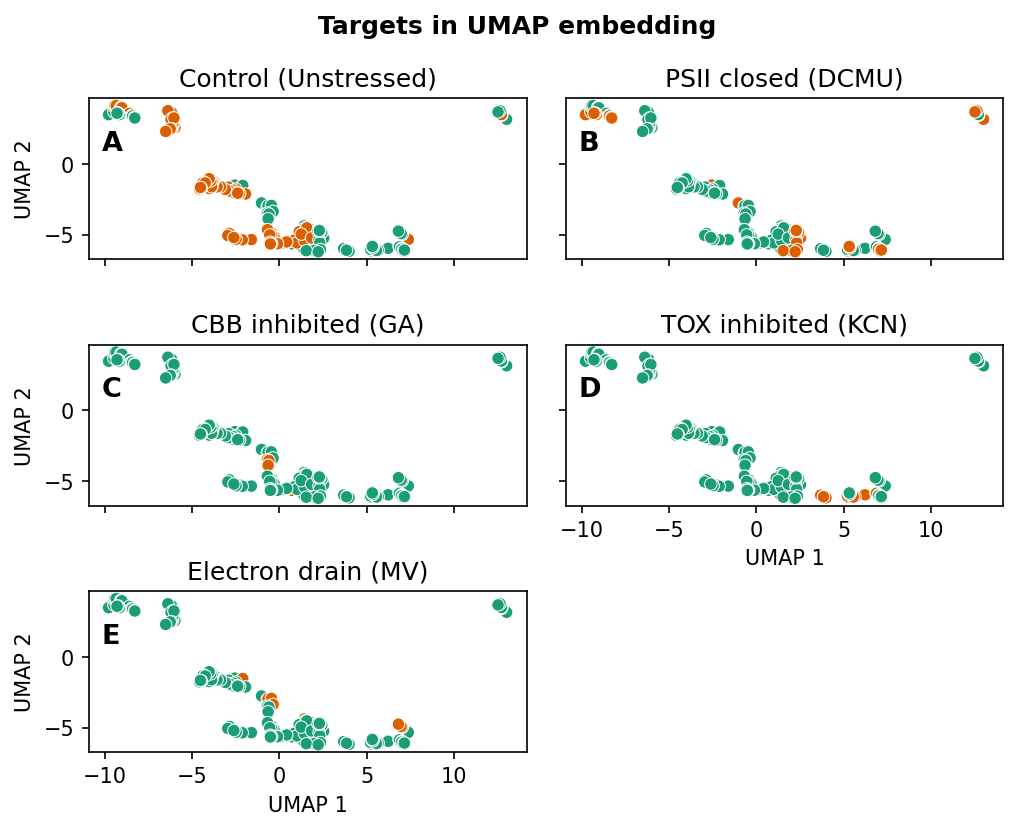

In [590]:
tl.thesis_figures["umap_targets_all"]["main"]

In [591]:
tl = reload(tl)

<Figure size 1050x840 with 0 Axes>

<Figure size 1050x840 with 0 Axes>

<Figure size 1050x840 with 0 Axes>

<Figure size 1050x1050 with 0 Axes>

<Figure size 1050x1260 with 0 Axes>

<Figure size 1050x1050 with 0 Axes>

<Figure size 1050x1260 with 0 Axes>

<Figure size 1050x1260 with 0 Axes>

In [592]:
# Extract only OJIP preprocessing
ojip_preprocess = keras.Model(
    all_inputs,
    preprocessed["ojip"],
    name="ojip_output"
)

# Scale the features
df_features_scaled = ojip_preprocess.predict(
    fnc.get_dataset_from_input_df(dat_full, all_inputs)
)

# Create the UMAP embedding
reducer = umap.UMAP(random_state=SEED)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=dat_full.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()


# Add UMAP to targets
embedding_targets = pd.concat([
    targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

# Plot
categories = effects_map.columns.get_level_values(0)
fig = tl.thesis_figures["umap_targets_ojip"]["main"]
axes = fig.subplots(
    int(np.ceil(len(categories)/2)),
    2,
    # sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(target_labels[category]["long"])

    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

for ax in axes.flatten()[:-3]:
    ax.tick_params(labelbottom=False)
    ax.set_xlabel("")

# axes[1,1].tick_params(bottom=True, labelbottom=True)
# axes[1,1].set_xlabel("UMAP 1")

fig.suptitle("Targets in OJIP-only UMAP embedding")

fig.tight_layout()

tl.label_axes(axes, pos=(0.03, 0.8), ha="left")

axes[-1,-1].remove()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


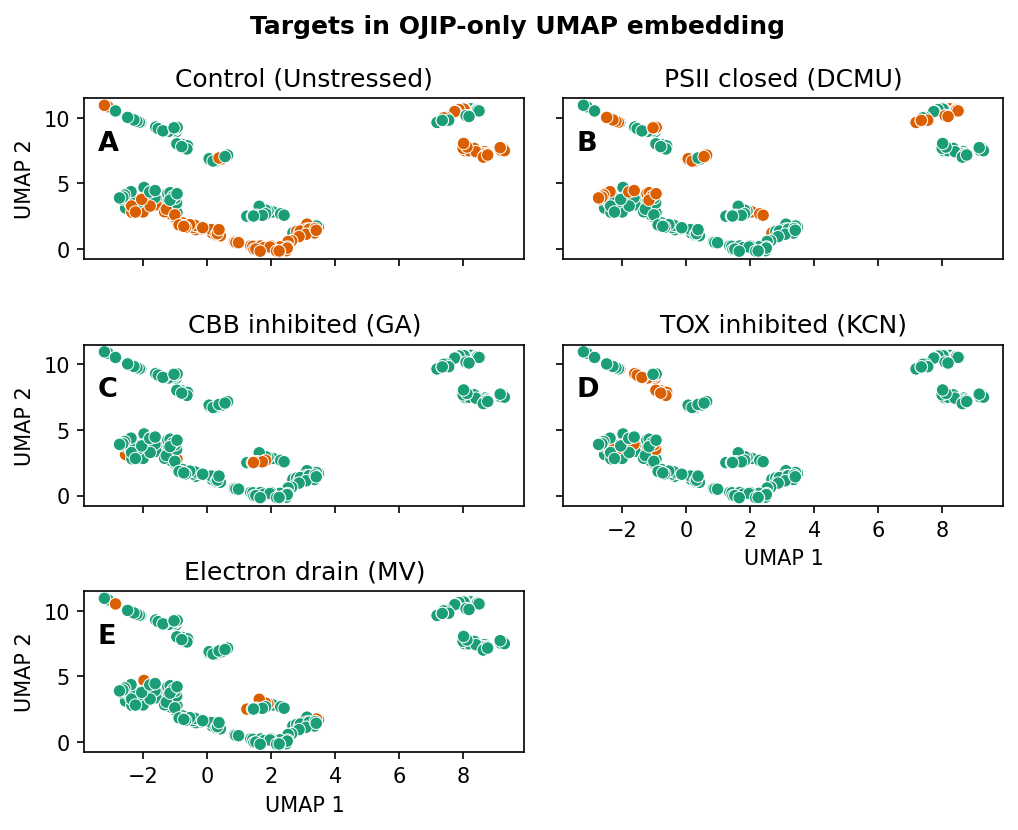

In [593]:
tl.thesis_figures["umap_targets_ojip"]["main"]

## Model functions

In [594]:
def split_output_to_dict(dense_output):
    outputs = {
        "control_measurement": layers.Lambda(lambda x: tf.expand_dims(x[:, 0], axis=-1), name="control_measurement")(dense_output),
        "PSII_closed": layers.Lambda(lambda x: tf.expand_dims(x[:, 1], axis=-1), name="PSII_closed")(dense_output),
        "CBB_inhibited": layers.Lambda(lambda x: tf.expand_dims(x[:, 2], axis=-1), name="CBB_inhibited")(dense_output),
        "TOX_inhibited": layers.Lambda(lambda x: tf.expand_dims(x[:, 3], axis=-1), name="TOX_inhibited")(dense_output),
        "electron_drain": layers.Lambda(lambda x: tf.expand_dims(x[:, 4], axis=-1), name="electron_drain")(dense_output),
    }
    return outputs

## Create dense model

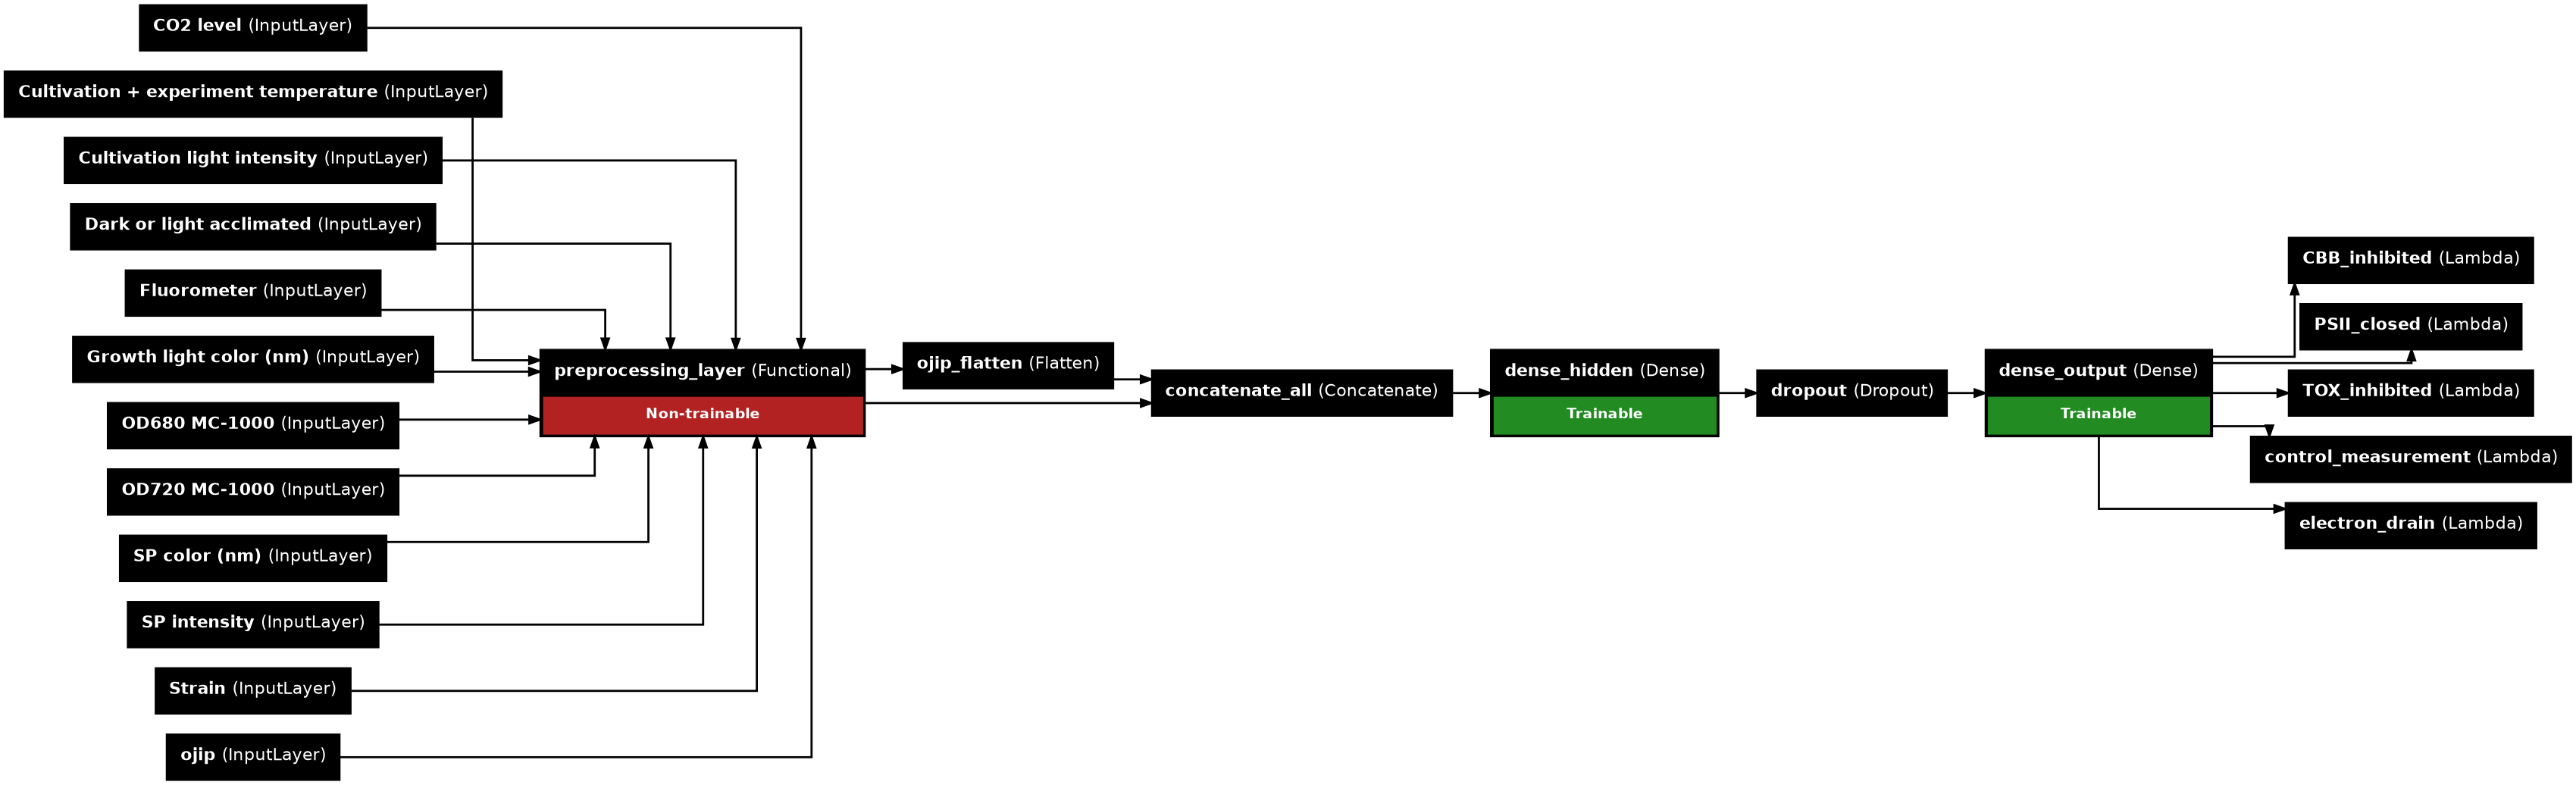

In [595]:
## Test model
# Get the preprocessed inputs

def get_dense_model(all_inputs, input = "full"):
    preprocessed = preprocessing_layer(all_inputs)

    # Append the derivatives of the ojip signal to the end to create a long feature vector
    preprocessed["ojip"] = layers.Flatten(name="ojip_flatten")(preprocessed["ojip"])

    if input == "ojip_only":
        # Use only the ojip values
        x = preprocessed["ojip"]
    elif input == "no_ojip":
        # Concatenate all features
        preprocessed.pop("ojip")
        x = layers.concatenate(list(preprocessed.values()), name="concatenate_all")
    elif input == "full":
        # Concatenate all features
        x = layers.concatenate(list(preprocessed.values()), name="concatenate_all")
    else:
        raise ValueError(f"{input} is not an accepted input")

    # Dense hidden layer
    x = layers.Dense(32, activation="relu", name="dense_hidden")(x)
    x = layers.Dropout(0.5, name="dropout")(x)

    # Dense layer for output calculation
    # Uses sigmoid activation function for output between 0 and 1
    dense_output = layers.Dense(targets.shape[1], activation="sigmoid", name="dense_output")(x)

    # Split the output into a dictionary
    outputs = split_output_to_dict(dense_output)
    # outputs = SplitOutput()(dense_output)

    # return outputs

    # Create and compile test model
    dense_model = keras.Model(all_inputs, outputs)
    dense_model.compile(
        loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
        optimizer='adam',
        metrics={key:[ # Calculate metrics for each target
            keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
            keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
            keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
            keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
            ] for key in target_names},
    )
    return dense_model

dense_model = get_dense_model(all_inputs)

# Plot the model
keras.utils.plot_model(
    dense_model,
    # show_shapes=True,
    show_layer_names=True,
    to_file="figures/dense_model.png",
    rankdir="LR",
    # rankdir="TB",
    # expand_nested=True,
    show_trainable=True,
    dpi=100
)

In [ ]:
# Train the model
dense_models = {
    "model": get_dense_model(all_inputs),
    "ojip_model": get_dense_model(all_inputs, input="ojip_only"),
    "condition_model": get_dense_model(all_inputs, input="no_ojip"),
    "baseline_model": get_dense_model(all_inputs),
}

dense_model_histories = {}

for name, model in dense_models.items():
    if name == "model":
        data = train_ds
    elif name == "baseline_model":
        data = train_ds_sfl

    # Use tensorboard to track the training
    use_tensorboard = False
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

    dense_model_histories[name] = model.fit(
        data,
        epochs=300,
        batch_size=32,
        verbose=0,
        validation_data=val_ds,
        callbacks=[
            TqdmCallback(verbose=1)
        ] + tensorboard_callback
    )

    # Plot the loss over the Epochs
    fig, ax = fnc.plot_loss_development(dense_model_histories[name], f" (Model: {name})")
    fig.savefig("figures/dense_loss.png")

### Plot the loss over time

In [596]:
model_labels = {
    "model": "Full model",
    "ojip_model": "OJIP-only model",
    "baseline_model": "Baseline model",
    "condition_model": "Condition-only model",
}

def plot_training_histories(histories, fig, plot_histories = ["model", "baseline_model"], label_axes=False, label_pos=(0.1,0.9)):

    # fig = tl.thesis_figures["dense_loss"]["main"]
    axes = fig.subplots(len(plot_histories), sharex=True, sharey=True)

    for i, name in enumerate(plot_histories):
        history = histories[name]
        ax = axes[i]

        # Get the training and validation loss
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]

        # Plot the loss curves
        ax.plot(train_loss, label="Training Data")
        ax.plot(val_loss, label="Validation Data")
        ax.set_ylabel("Binary\ncrossentropy [AU]")
        ax.set_title(f"{model_labels[name]}")
        ax.set_ylim(0)
        if i == 0:
            ax.legend(title="Data for\nloss calculation", loc="upper right")
        ax.grid()

    axes[-1].set_xlabel("Epoch No.")

    # fig.suptitle("Dense Model: Training Loss Over Epochs")
    fig.tight_layout()

    if label_axes:
        tl.label_axes(axes, pos=label_pos,ha="left")

    return fig


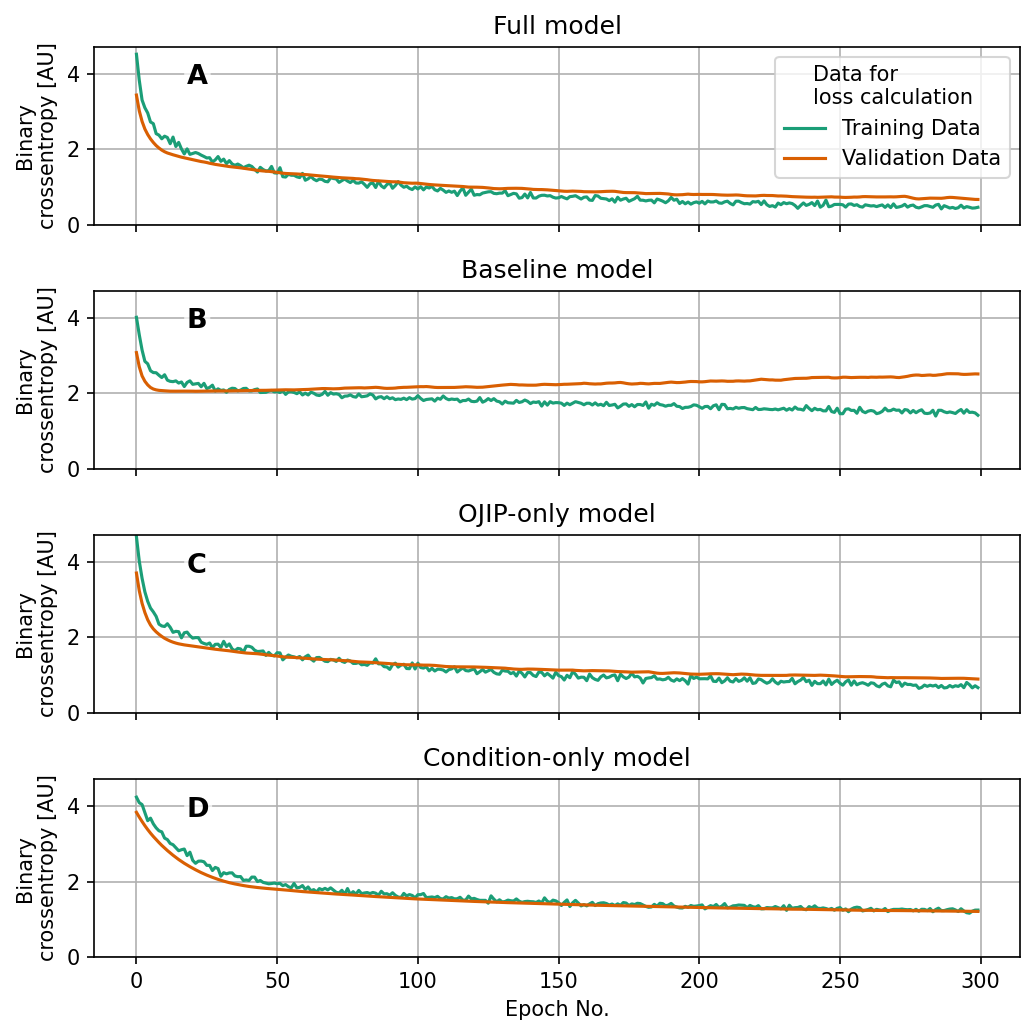

In [597]:
# Plot the training loss
plot_training_histories(
    dense_model_histories, 
    tl.thesis_figures["dense_loss"]["main"], 
    plot_histories = ["model", "baseline_model","ojip_model", "condition_model"],
    label_axes=True
)

# plot_training_histories(
#     dense_model_histories, 
#     tl.thesis_figures["dense_loss_supp"]["main"], 
#     plot_histories = ["ojip_model", "condition_model"]
# )

### Evaluate on the test data

In [598]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Store all metrics across models
def colors(i, name):
    return tl.default_cmap(i) if name != "baseline_model" else "gray"

metrics_labels = {
    'binary_accuracy': "Binary accuracy",
    'f1_score': "F1 score",
    'precision': "Precision",
    'recall': "Recall"
}

def get_model_metrics(models, dataset, fig, plot_metrics_names = ['f1_score', 'precision', 'recall', 'binary_accuracy']):
    all_plot_metrics = {}
    target_number = None  # Will be set once for the top plot

    for name, model in models.items():
        metrics = model.evaluate(dataset, return_dict=True)
        
        # Extract targets to count occurrences
        _targets_subsets = list(dataset.map(lambda x, y: y).as_numpy_iterator())
        _targets = [pd.DataFrame({k: v.flatten() for k, v in subset.items()}) for subset in _targets_subsets]
        _targets = pd.concat(_targets, axis=0)
        
        if target_number is None:
            target_number = _targets.sum().sort_values(ascending=False)

        # Prepare metric values, skip loss
        plot_metrics = pd.Series(
            {tuple(k.split("_..")): v for k, v in metrics.items() if not k.endswith("loss")}
        )
        
        # Store for grouped bar plot
        all_plot_metrics[name] = plot_metrics

    return all_plot_metrics

def compare_model_metrics(models, dataset, fig, plot_metrics_names = ['f1_score', 'precision', 'recall', 'binary_accuracy'], label_axes=False, label_pos=(0.01,0.9)):
    all_plot_metrics = {}
    target_number = None  # Will be set once for the top plot

    for name, model in models.items():
        metrics = model.evaluate(dataset, return_dict=True)
        
        # Extract targets to count occurrences
        _targets_subsets = list(dataset.map(lambda x, y: y).as_numpy_iterator())
        _targets = [pd.DataFrame({k: v.flatten() for k, v in subset.items()}) for subset in _targets_subsets]
        _targets = pd.concat(_targets, axis=0)
        
        if target_number is None:
            target_number = _targets.sum().sort_values(ascending=False)

        # Prepare metric values, skip loss
        plot_metrics = pd.Series(
            {tuple(k.split("_..")): v for k, v in metrics.items() if not k.endswith("loss")}
        )
        
        # Store for grouped bar plot
        all_plot_metrics[name] = plot_metrics

    # Setup plots
    num_metrics = len(plot_metrics_names)
    axes = fig.subplots(num_metrics + 2, 1, sharex=True, height_ratios=[1,0.1]+ num_metrics * [1])

    axes[1].remove()
    axes = np.concatenate([[axes[0]], axes[2:]])

    print(axes)

    # Define bar width and model colors
    bar_width = 0.8 / len(models)
    model_names = list(models.keys())

    # Plot top chart: number of samples
    axes[0].bar(np.arange(len(target_number)) + bar_width * len(model_names)/2, target_number.values)
    axes[0].set_title("Number of test samples")
    axes[0].set_ylabel("Number\nof samples")
    axes[0].set_xticks(range(len(target_number)))
    axes[0].set_xticklabels(target_number.index)
    axes[0].grid(which="both")

    # Plot metrics as grouped bar plots
    for i, metric in enumerate(target_number.index):
        for j, metric_name in enumerate(plot_metrics_names):
            ax = axes[j+1]
            for k, model_name in enumerate(model_names):
                metric_series = all_plot_metrics[model_name]
                bar_value = metric_series.loc[(metric, metric_name)]
                ax.bar(
                    i + k * bar_width,
                    bar_value,
                    width=bar_width,
                    color=colors(k, model_name),
                    label=model_labels[model_name] if i == 0 else ""
                )
            ax.set_title(metrics_labels[metric_name])
            ax.set_ylabel(f"{metrics_labels[metric_name]} [AU]")
            ax.set_xticks(np.arange(len(target_number)) + bar_width * (len(model_names) - 1) / 2)
            ax.set_xticklabels([target_labels[l]["short"] for l in  target_number.index])
            ax.grid(which="both")

    fig.tight_layout()

    # Add legend to the last plot
    axes[1].legend(ncol=len(model_names), loc="lower center", bbox_to_anchor=(0.5,1.3))

    if label_axes:
        tl.label_axes(axes, pos=label_pos,ha="left")

    return fig, axes


In [599]:
_metrics = get_model_metrics(dense_models, test_ds, tl.thesis_figures["dense_metrics"]["main"])

print("### F1-Scores ###")
for model in _metrics:
    print(model,"\n",_metrics[model].loc[idx[:, "f1_score"]],"\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - CBB_inhibited_..binary_accuracy: 0.9629 - CBB_inhibited_..f1_score: 0.5556 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.3889 - CBB_inhibited_loss: 0.1445 - PSII_closed_..binary_accuracy: 0.9629 - PSII_closed_..f1_score: 0.9091 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.8333 - PSII_closed_loss: 0.1313 - TOX_inhibited_..binary_accuracy: 0.9762 - TOX_inhibited_..f1_score: 0.8783 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 0.7833 - TOX_inhibited_loss: 0.0642 - control_measurement_..binary_accuracy: 0.9258 - control_measurement_..f1_score: 0.9328 - control_measurement_..precision: 0.9114 - control_measurement_..recall: 0.9557 - control_measurement_loss: 0.2458 - electron_drain_..binary_accuracy: 1.0000 - electron_drain_..f1_score: 1.0000 - electron_drain_..precision: 1.0000 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0365 - loss: 0.6187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - CBB_inh

In [600]:
model_loss = dense_model_histories["model"].history["loss"][-1]
ojip_loss = dense_model_histories["ojip_model"].history["loss"][-1]

print(f'Final loss value in OJIP monly model: {ojip_loss:.3f} ({((ojip_loss - model_loss) / model_loss)*100:.1f}%)')

Final loss value in OJIP monly model: 0.671 (45.9%)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - CBB_inhibited_..binary_accuracy: 0.9629 - CBB_inhibited_..f1_score: 0.5556 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.3889 - CBB_inhibited_loss: 0.1445 - PSII_closed_..binary_accuracy: 0.9629 - PSII_closed_..f1_score: 0.9091 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.8333 - PSII_closed_loss: 0.1313 - TOX_inhibited_..binary_accuracy: 0.9762 - TOX_inhibited_..f1_score: 0.8783 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 0.7833 - TOX_inhibited_loss: 0.0642 - control_measurement_..binary_accuracy: 0.9258 - control_measurement_..f1_score: 0.9328 - control_measurement_..precision: 0.9114 - control_measurement_..recall: 0.9557 - control_measurement_loss: 0.2458 - electron_drain_..binary_accuracy: 1.0000 - electron_drain_..f1_score: 1.0000 - electron_drain_..precision: 1.0000 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0365 - loss: 0.6187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - CBB_inh

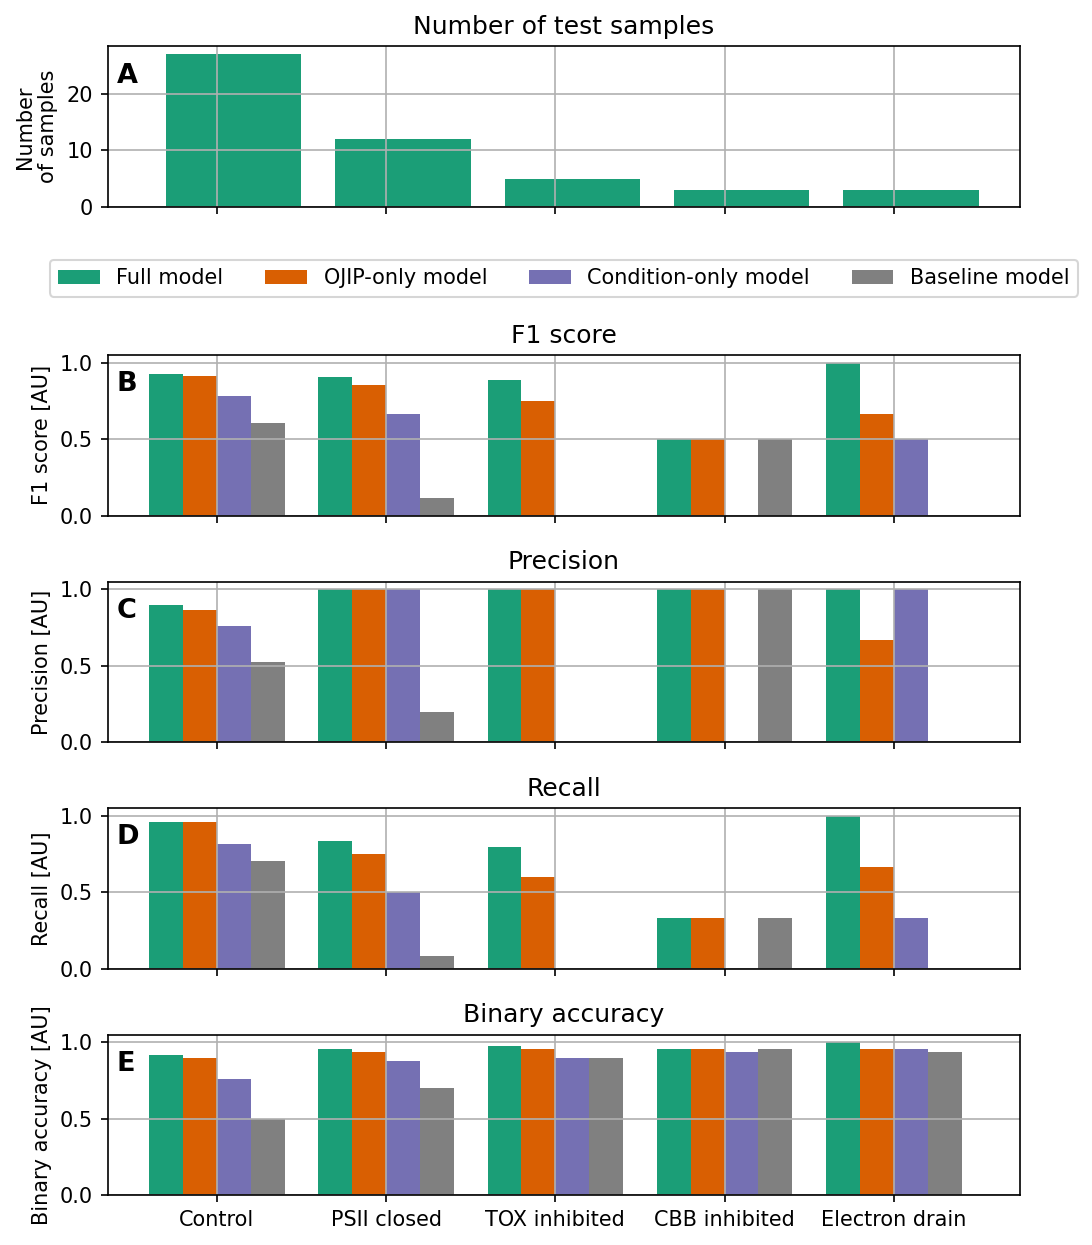

In [601]:
from thesis_layout import label_axes


compare_model_metrics(
    dense_models, 
    test_ds, 
    tl.thesis_figures["dense_metrics"]["main"],
    label_axes=True
)
tl.thesis_figures["dense_metrics"]["main"]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - CBB_inhibited_..binary_accuracy: 0.9629 - CBB_inhibited_..f1_score: 0.5556 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.3889 - CBB_inhibited_loss: 0.1445 - PSII_closed_..binary_accuracy: 0.9629 - PSII_closed_..f1_score: 0.9091 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.8333 - PSII_closed_loss: 0.1313 - TOX_inhibited_..binary_accuracy: 0.9762 - TOX_inhibited_..f1_score: 0.8783 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 0.7833 - TOX_inhibited_loss: 0.0642 - control_measurement_..binary_accuracy: 0.9258 - control_measurement_..f1_score: 0.9328 - control_measurement_..precision: 0.9114 - control_measurement_..recall: 0.9557 - control_measurement_loss: 0.2458 - electron_drain_..binary_accuracy: 1.0000 - electron_drain_..f1_score: 1.0000 - electron_drain_..precision: 1.0000 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0365 - loss: 0.6187
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - CBB_inhi

Text(0.5, 1, 'Increase in metric for training data')

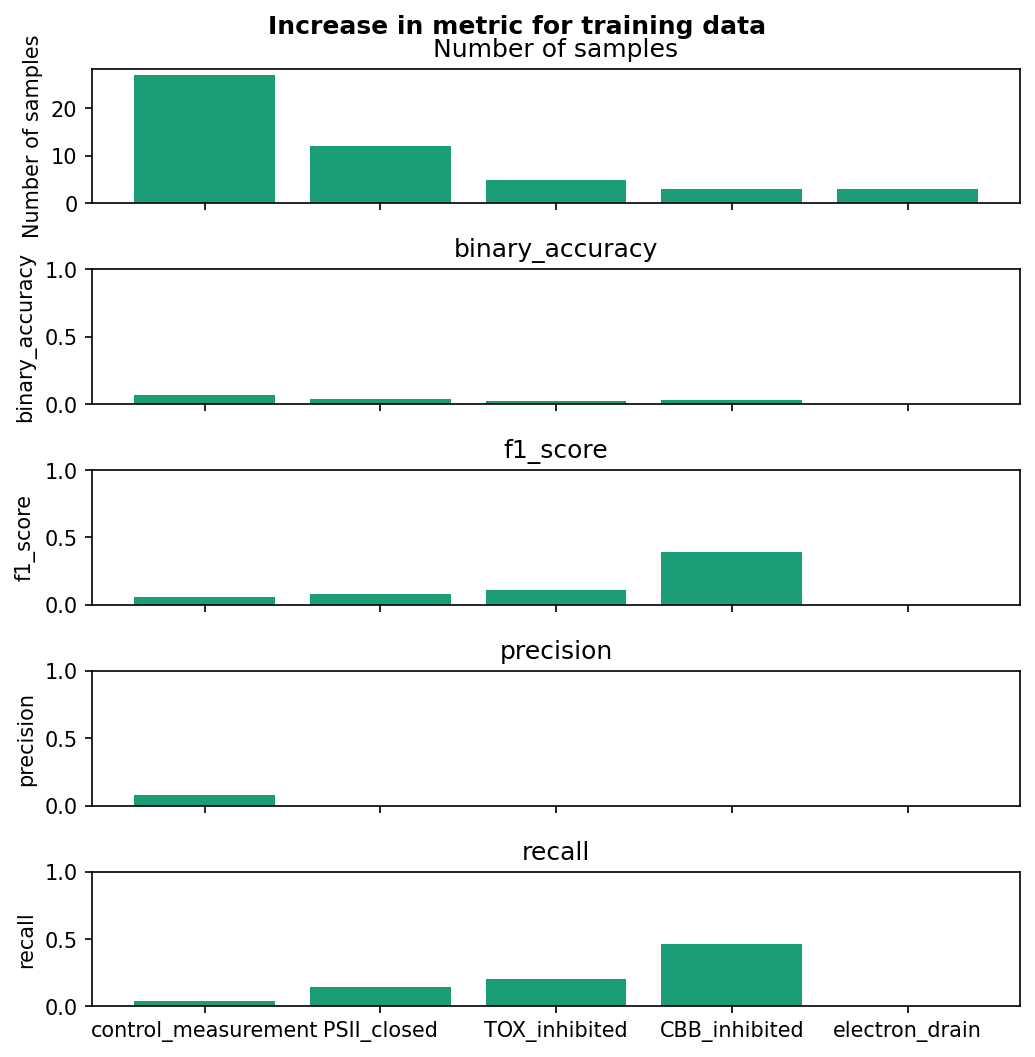

In [602]:
# Calculate the metrics for the training data to compare with test data and evaluate overfitting
# Evaluate the model on the test data
dense_model = dense_models["model"]
dense_model_eval = dense_model.evaluate(test_ds, return_dict=True)

dense_model_eval_train = dense_model.evaluate(train_ds, return_dict=True)

dense_model_eval_compare = {x:(dense_model_eval_train[x] - dense_model_eval[x]) for x in dense_model_eval}

fig, axes = fnc.plot_model_metrics(dense_model_eval_compare, test_ds, ylim=(0,1))
fig.suptitle("Increase in metric for training data", y=1, weight="bold")

# Create LSTM model

In [ ]:
## Define the model
def get_lstm_model(all_inputs, input = "full"):
    # Get the preprocessed inputs
    seperated_inputs = preprocessing_layer(all_inputs)

    # Add an LSTM layer to the OJIP input
    seperated_inputs["ojip"] = layers.LSTM(16, activation="tanh", name="lstm_ojip")(seperated_inputs["ojip"])
    seperated_inputs["ojip"] = layers.Dropout(0.5, name="dropout_lstm")(seperated_inputs["ojip"])

    if input == "ojip_only":
        # Use only the ojip values
        x = seperated_inputs["ojip"]
    elif input == "no_ojip":
        # Concatenate all features but ojip
        seperated_inputs.pop("ojip")
        x = layers.concatenate(list(seperated_inputs.values()), name="concatenate_all")
    elif input == "full":
        # Concatenate all features
        x = layers.concatenate(list(seperated_inputs.values()), name="concatenate_all")

    # Dense hidden layer
    x = layers.Dense(16, activation="relu", name="dense_hidden")(x)
    x = layers.Dropout(0.5, name="dropout_dense")(x)

    # Dense layer for output calculation
    # Uses sigmoid activation function for output between 0 and 1
    dense_output = layers.Dense(targets.shape[1], activation="sigmoid", name="dense_output")(x)

    # Split the output into a dictionary
    outputs = split_output_to_dict(dense_output)
    # outputs = SplitOutput()(dense_output)

    # Create and compile test model
    model = keras.Model(all_inputs, outputs)
    model.compile(
        loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
        optimizer='adam',
        metrics={key:[ # Calculate metrics for each target
            keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
            keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
            keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
            keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
            ] for key in target_names},
    )

    return model

lstm_model = get_lstm_model(all_inputs)

# Plot the model
keras.utils.plot_model(
    lstm_model,
    # show_shapes=True,
    show_layer_names=True,
    to_file="figures/lstm_model.png",
    rankdir="LR",
    show_trainable=True,
    dpi=100
)

In [ ]:
# Train the model

lstm_models = {
    "model": get_lstm_model(all_inputs),
    "ojip_model": get_lstm_model(all_inputs, input="ojip_only"),
    "condition_model": get_lstm_model(all_inputs, input="no_ojip"),
    "baseline_model": get_lstm_model(all_inputs),
}

lstm_model_histories = {}

for name, model in lstm_models.items():
    if name == "model":
        data = train_ds
    elif name == "baseline_model":
        data = train_ds_sfl

    # Use tensorboard to track the training
    use_tensorboard = False
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

    lstm_model_histories[name] = model.fit(
        data,
        epochs=800,
        verbose=0,
        validation_data=val_ds,
        callbacks=[
            TqdmCallback(verbose=1)
        ] + tensorboard_callback
    )

    # Plot the loss over the Epochs
    fig, ax = fnc.plot_loss_development(lstm_model_histories[name], f" (Model: {name})")
    fig.savefig("figures/lstm_loss.png")

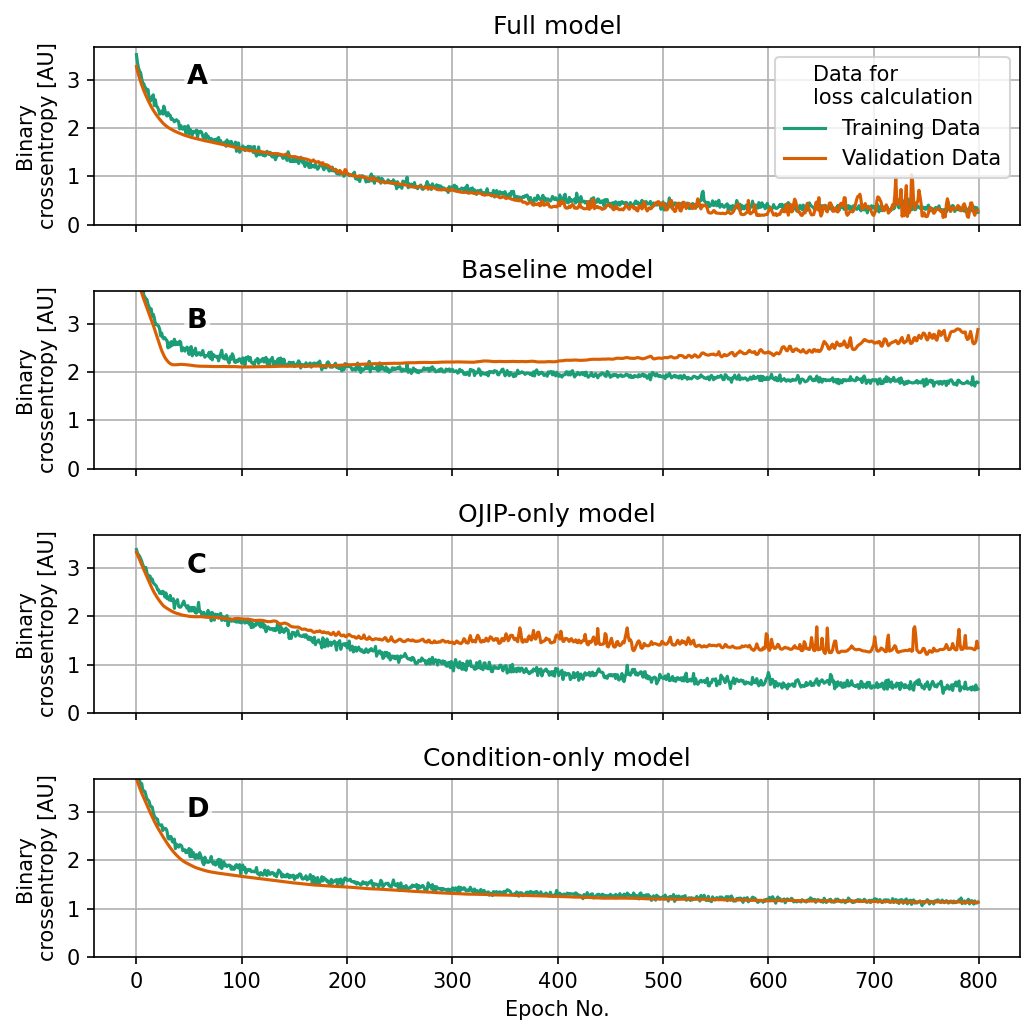

In [603]:
# Plot the training loss
plot_training_histories(
    lstm_model_histories, 
    tl.thesis_figures["lstm_loss"]["main"], 
    plot_histories = ["model", "baseline_model","ojip_model", "condition_model"],
    label_axes=True
)

# plot_training_histories(
#     lstm_model_histories, 
#     tl.thesis_figures["lstm_loss_supp"]["main"], 
#     plot_histories = ["ojip_model", "condition_model"]
# )

In [604]:
lstm_loss = lstm_model_histories["model"].history["loss"][-1]
dense_loss = dense_model_histories["model"].history["loss"][-1]

print(f'Final loss value in LSTM model: {lstm_loss:.3f} ({((lstm_loss - dense_loss) / dense_loss)*100:.1f}% to dense)')

Final loss value in LSTM model: 0.254 (-44.8% to dense)


In [605]:
model_loss = lstm_model_histories["model"].history["loss"][-1]
ojip_loss = lstm_model_histories["ojip_model"].history["loss"][-1]

print(f'Final loss value in OJIP only model: {ojip_loss:.3f} ({((ojip_loss - model_loss) / model_loss)*100:.1f}%)')

Final loss value in OJIP only model: 0.496 (95.5%)


In [606]:
val_loss = lstm_model_histories["ojip_model"].history["val_loss"][-1]
train_loss = lstm_model_histories["ojip_model"].history["loss"][-1]

print(f'Final validation loss value in OJIP only model: {val_loss:.3f} ({((val_loss - train_loss) / train_loss)*100:.1f}%)')

Final validation loss value in OJIP only model: 1.347 (171.5%)


### Evaluate on test data

In [607]:
dense_metrics = get_model_metrics(dense_models, test_ds, tl.thesis_figures["dense_metrics"]["main"])
lstm_metrics = get_model_metrics(lstm_models, test_ds, tl.thesis_figures["dense_metrics"]["main"])

print("### F1-Score increase (in %) ###")
for model in _metrics:
    dense_metric = dense_metrics[model].loc[idx[:, "f1_score"]]
    lstm_metric = lstm_metrics[model].loc[idx[:, "f1_score"]]
    print(model,"\n",(lstm_metric-dense_metric) / dense_metric * 100)
    print("Average",((lstm_metric-dense_metric) / dense_metric * 100).mean(),"\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - CBB_inhibited_..binary_accuracy: 0.9629 - CBB_inhibited_..f1_score: 0.5556 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.3889 - CBB_inhibited_loss: 0.1445 - PSII_closed_..binary_accuracy: 0.9629 - PSII_closed_..f1_score: 0.9091 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.8333 - PSII_closed_loss: 0.1313 - TOX_inhibited_..binary_accuracy: 0.9762 - TOX_inhibited_..f1_score: 0.8783 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 0.7833 - TOX_inhibited_loss: 0.0642 - control_measurement_..binary_accuracy: 0.9258 - control_measurement_..f1_score: 0.9328 - control_measurement_..precision: 0.9114 - control_measurement_..recall: 0.9557 - control_measurement_loss: 0.2458 - electron_drain_..binary_accuracy: 1.0000 - electron_drain_..f1_score: 1.0000 - electron_drain_..precision: 1.0000 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0365 - loss: 0.6187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - CBB_inh

In [608]:
print(f'Average Full model F1-score: {lstm_metrics["model"].loc[idx[:, "f1_score"]].mean():.3f}')

Average Full model F1-score: 0.843


In [609]:
print(f'Average OJIP-only F1-score: {lstm_metrics["ojip_model"].loc[idx[:, "f1_score"]].mean():.3f}')

Average OJIP-only F1-score: 0.642


In [610]:
print(f'Dense model parameter count: {dense_models["model"].count_params()}')
print(f'LSTM model parameter count: {lstm_models["model"].count_params()}')

Dense model parameter count: 4974
LSTM model parameter count: 2110


In [612]:
lstm_models["model"].summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ CO2 level           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Cultivation +       │ (None, 1)         │          0 │ -                 │
│ experiment          │                   │            │                   │
│ temperature         │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Cultivation light   │ (None, 1)         │          0 │ -                 │
│ intensity           │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dark or light       │ (None, 1)         │          0 │ -                 │
│ acclimated          │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fluorometer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Growth light color  │ (None, 1)         │          0 │ -                 │
│ (nm) (InputLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OD680 MC-1000       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OD720 MC-1000       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SP color (nm)       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SP intensity        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Strain (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ojip (InputLayer)   │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_layer │ [(None, 3),       │          9 │ CO2 level[0][0],  │
│ (Functional)        │ (None, 5), (None, │            │ Cultivation +     │
│                     │ 1), (None, 3),    │            │ experiment        │
│                     │ (None, 3), (None, │            │ temperature[0][0… │
│                     │ 2), (None, 1),    │            │ Cultivation light │
│                     │ (None, 1), (None, │            │ intensity[0][0],  │
│                     │ 3), (None, 4),    │            │ Dark or light     │
│                     │ (None, 3), (None, │            │ acclimated[0][0], │
│                     │ 40, 3)]           │            │ Fluorometer[0][0… │
│                     │                   │            │ Growth light      │
│                     │                   │            │ color (nm)[0][0]

 Total params: 6,314 (24.68 KB)

 Trainable params: 2,101 (8.21 KB)

 Non-trainable params: 9 (48.00 B)

 Optimizer params: 4,204 (16.43 KB)

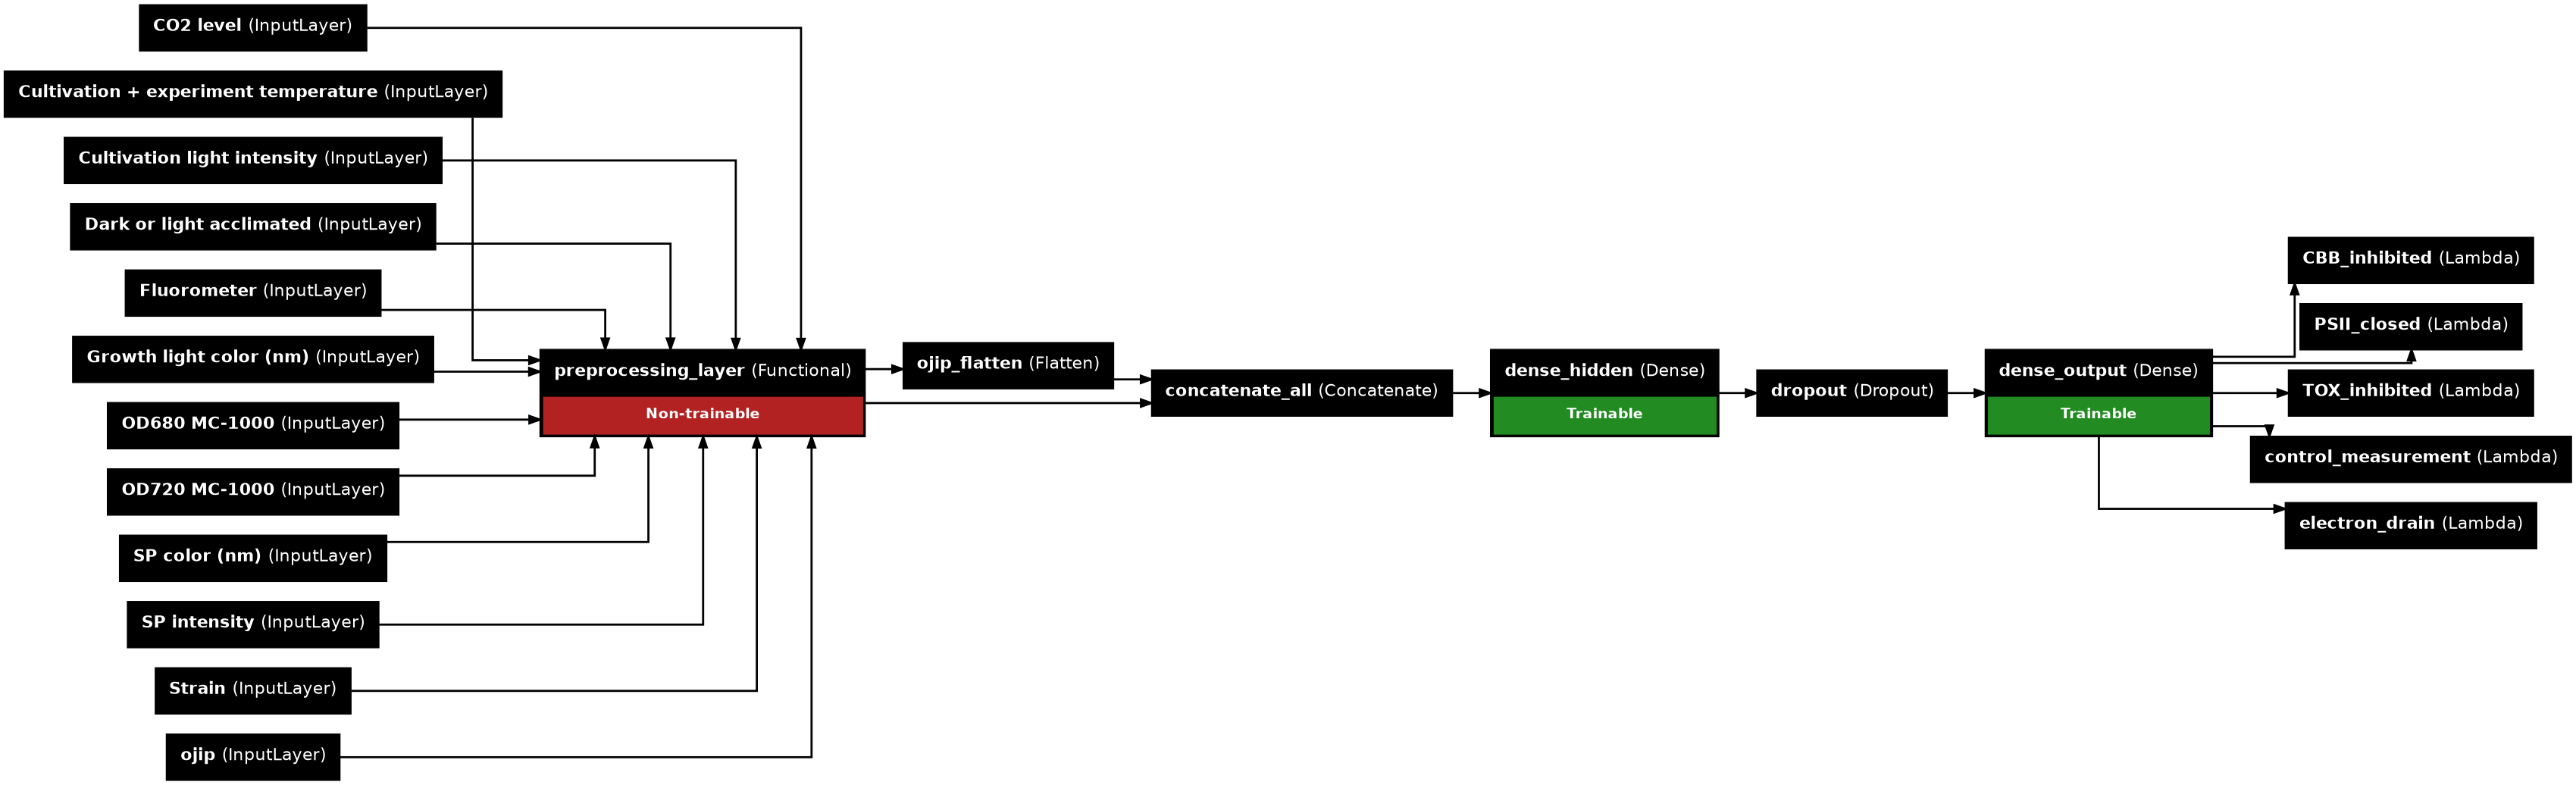

In [613]:
# Plot the model
keras.utils.plot_model(
    dense_model,
    # show_shapes=True,
    show_layer_names=True,
    to_file="figures/dense_model.png",
    rankdir="LR",
    # rankdir="TB",
    # expand_nested=True,
    show_trainable=True,
    dpi=100
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - CBB_inhibited_..binary_accuracy: 0.9629 - CBB_inhibited_..f1_score: 0.5556 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.3889 - CBB_inhibited_loss: 0.1600 - PSII_closed_..binary_accuracy: 0.9629 - PSII_closed_..f1_score: 0.9091 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.8333 - PSII_closed_loss: 0.2274 - TOX_inhibited_..binary_accuracy: 1.0000 - TOX_inhibited_..f1_score: 1.0000 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 1.0000 - TOX_inhibited_loss: 0.0131 - control_measurement_..binary_accuracy: 0.9496 - control_measurement_..f1_score: 0.9554 - control_measurement_..precision: 0.9148 - control_measurement_..recall: 1.0000 - control_measurement_loss: 0.2603 - electron_drain_..binary_accuracy: 0.9762 - electron_drain_..f1_score: 0.8571 - electron_drain_..precision: 0.7500 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0502 - loss: 0.6475
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - CBB_inh

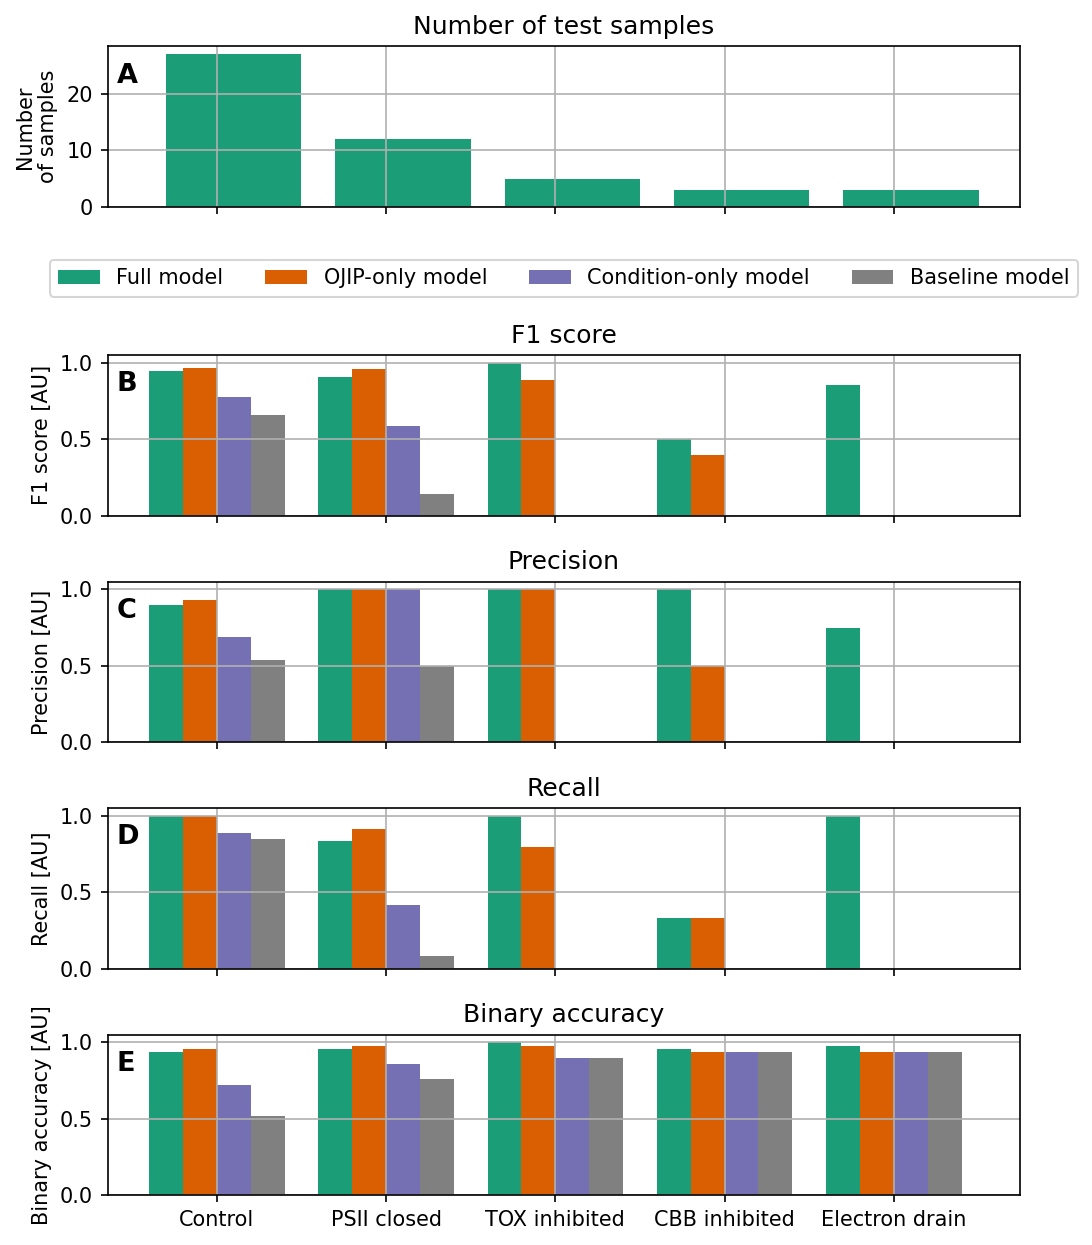

In [614]:
compare_model_metrics(
    lstm_models,
    test_ds, 
    tl.thesis_figures["lstm_metrics"]["main"],
    label_axes=True
)
tl.thesis_figures["lstm_metrics"]["main"]

In [615]:
# Plot the final metrics of a model
def plot_history_metrics(history, fit_dataset, val_dataset, fig, plot_metrics_names=['f1_score', 'precision', 'recall', 'binary_accuracy'], label_axes=False, label_pos=(0.01,0.97)):
    # Get the targets from the dataset to count occurrences
    target_numbers={}
    for nam, ds in {"fit":fit_dataset, "val":val_dataset}.items():
        _targets_subsets = list(ds.map(lambda x,y: y).as_numpy_iterator())
        _targets = [pd.DataFrame({k:v.flatten() for k,v in _targets_subset.items()}) for _targets_subset in _targets_subsets]
        _targets = pd.concat(_targets, axis=0)

        target_numbers[nam] = _targets.sum().sort_values(ascending=False)

    metrics = history.history

    # Get all metrics and assign them to the targets
    plot_metrics = pd.DataFrame(
        {tuple(k.split("_..")): v for k,v in metrics.items() if not k.endswith("loss")}
    )

    targets_names = _targets.columns

    # Create the figure

    axes = fig.subplots(
        len(targets_names), 
        2,
        sharex=True,
        sharey=True
    )

    # Plot each target
    for j, val in enumerate(["fit", "val"]):
        for i, _target in enumerate(targets_names):
            prefix = "val_" if val=="val" else ""
            target = prefix + _target
            axes[i, j].plot(
                plot_metrics.loc[:, idx[target, plot_metrics_names]],
                label=[metrics_labels[x] for x in plot_metrics_names]
            )
            axes[i, j].set_title(f"{target_labels[_target]['short']} (n={target_numbers[val][_target]})")

            # print(plot_metrics.loc[:, idx[target, plot_metrics_names]])

        axes[-1, j].set_xlabel("Epoch No.")

    for ax in axes[:,0]:
        ax.set_ylabel("Metric [AU]")

    for ax in axes.flatten():
        ax.set_ylim(0,1)

    for i, label in enumerate(["Training data", "Validation data"]):
        fig.text(0.3 if i==0 else 0.75, 0.99, label, ha="center", fontsize=15)

    fig.tight_layout()

    # axes[-1, -1].legend(loc="upper center", bbox_to_anchor=(0.5,-0.5), ncols=4)
    fig. legend(handles=axes[-1, -1].get_lines(),loc="lower center", bbox_to_anchor=(0.5,1.03), ncols=4)

    if label_axes:
        tl.label_axes(axes, pos=label_pos,ha="left")

    return fig, axes

In [616]:
fig, axes = plot_history_metrics(history=lstm_model_histories["ojip_model"], fit_dataset=train_ds, val_dataset=val_ds, fig=tl.thesis_figures["lstm_metrics_over_time"]["main"], label_axes=True)

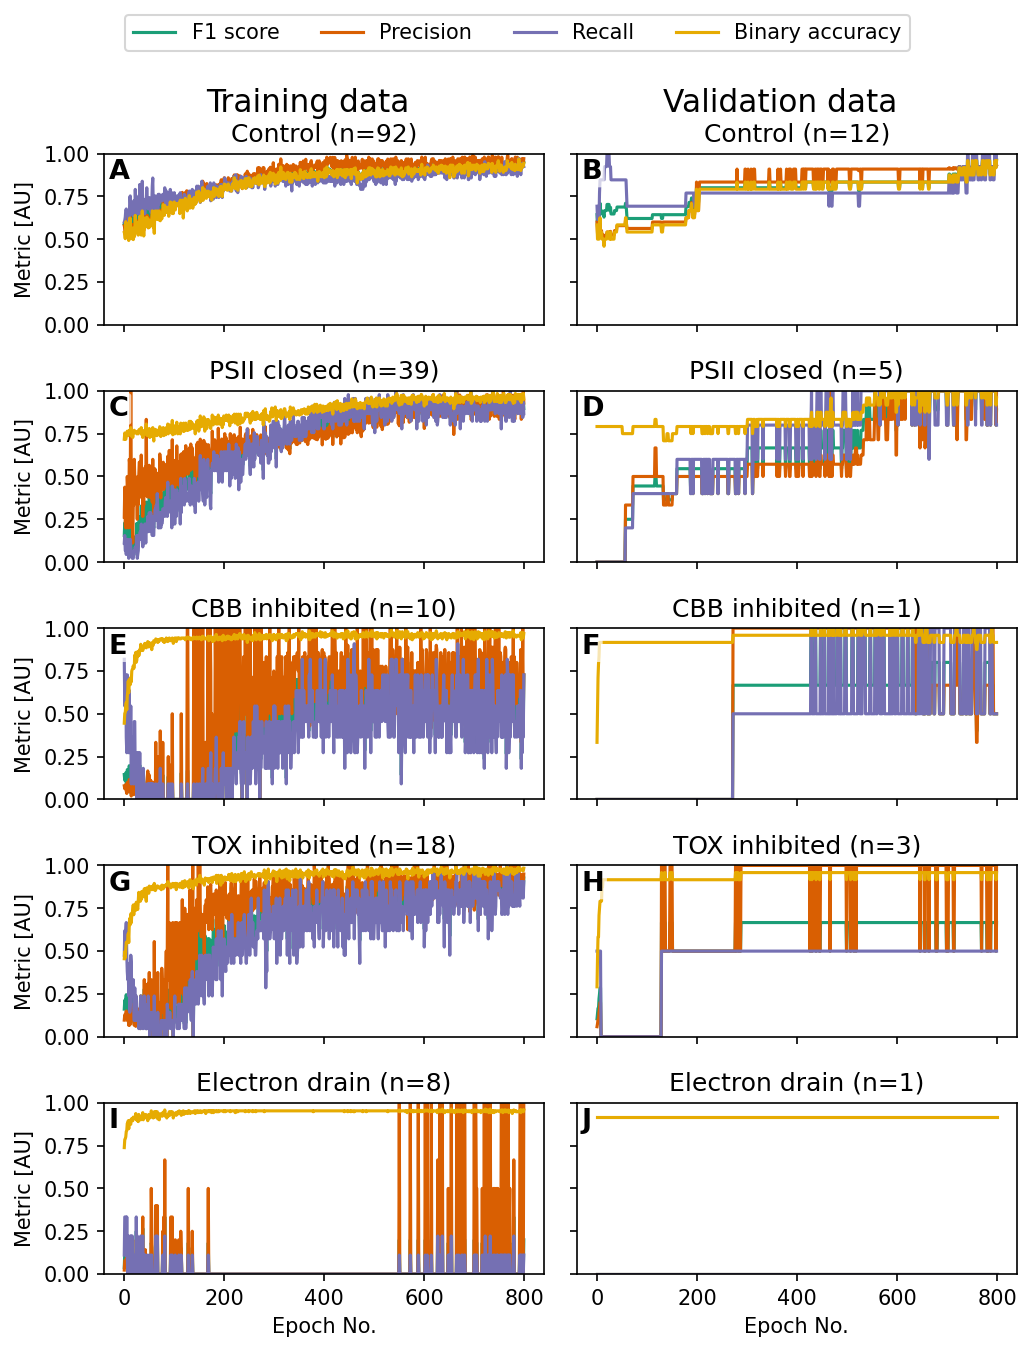

In [617]:
tl.thesis_figures["lstm_metrics_over_time"]["main"]

# Save the models

In [ ]:
# Make a folder for the models
save_dir = Path(f"out/{datetime.datetime.now().strftime('%Y%m%d%H%M')}_models")
os.mkdir(save_dir)

for name, _models, _histories in zip(["dense", "lstm"], [dense_models, lstm_models], [dense_model_histories, lstm_model_histories]):
    for _model in _models:
        _models[_model].save(save_dir/f"{name}_{_model}.keras")
        with open(save_dir/f"{name}_{_model}_history.pickle", "wb") as f:
            pickle.dump(_histories[_model], f)

In [ ]:
def load_models_and_histories(folder_path, model_name):
    models = {}
    histories = {}

    for filename in os.listdir(folder_path):
        if filename.startswith(model_name + "_"):
            file_path = os.path.join(folder_path, filename)

            # Load model
            if filename.endswith(".keras") and not filename.endswith("_history.pickle"):
                model_type = filename[len(model_name) + 1:-6]  # remove model_name_ and .keras
                models[model_type] = keras.models.load_model(file_path)

            # Load history
            # elif filename.endswith("_history.pickle"):
            #     model_type = filename[len(model_name) + 1:-16]  # remove model_name_ and _history.pickle
            #     with open(file_path, 'rb') as f:
            #         histories[model_type] = pickle.load(f)

    return models, histories


In [ ]:
test_models, test_histories = load_models_and_histories("out/202506132100_models", "dense")

# Save all plots

In [ ]:
for fig_nam in tl.thesis_figures:
    # fnc.savefig_dated(tl.thesis_figures[fig_nam]["main"], fig_nam, type=tl.export_formats, path="figures/thesis_figures", bbox_inches="tight", format='%Y%m%d', dpi=tl.export_dpi)
    for exp in tl.export_formats:
        tl.thesis_figures[fig_nam]["main"].savefig(
            f"figures/thesis_figures/{fig_nam}.{exp}",
            bbox_inches="tight",
            dpi=tl.export_dpi
        )